In [2]:
import os
import sys
cwd = os.getcwd()
parent_wd = cwd.replace('/notebooks', '')
sys.path.insert(1, parent_wd)
from microsporidia_util.microsporidia_helpers import *
data_path = parent_wd + '/raw_data/'
output_path = parent_wd + '/output_figures/'

import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
from scipy import integrate
import uncertainties.unumpy as unp
import uncertainties as unc
import string

Note that trace 85 of 1% MC is removed because of its obvious outlier behavior.

## Re-run the analysis on buffer viscosity (Fig S3)

In [3]:
# load the data
viscosity_data = pickle.load(open(data_path + "viscosity_data", "rb"))

To correctly interpret rheometer data, we need to at least consider 2 potential error -- the low torque limit and secondary flow limit. These two limits will depend on specific geometry of the measurement tool, and the measurement limit. Here we used ARES-G2 rheometer, with a Couette geometry for 0%MC, 0.5%MC, 1%MC measurements, and a 40mm cone-and-plate geometry for 2%MC, 3%MC, and 4%MC measurement.

In [5]:
# Couette geometry
Db = 27.671E-3
Rb = Db/2
Dc = 29.986E-3
Rc = Dc/2
delta = Rc/Rb
cL = 1.1
L = 41.59E-3
F_tau_couette = (1 + delta**2)/(4*np.pi*L*Rb**2*cL*delta**2)
F_gamma_couette = (1 + delta**2)/(delta**2 - 1)

# 40mm cone-and-plate geometry
D = 40E-3
R = D/2
beta = 0.035
F_tau = 3/(2*np.pi*R**3)
F_gamma = 1/beta

# rheometer detection limit and measurement range
T_min = .1E-6
shear_rate_range = 10.**(np.linspace(-1, 4, 20))
rho = 1000
Re_max = 4.05

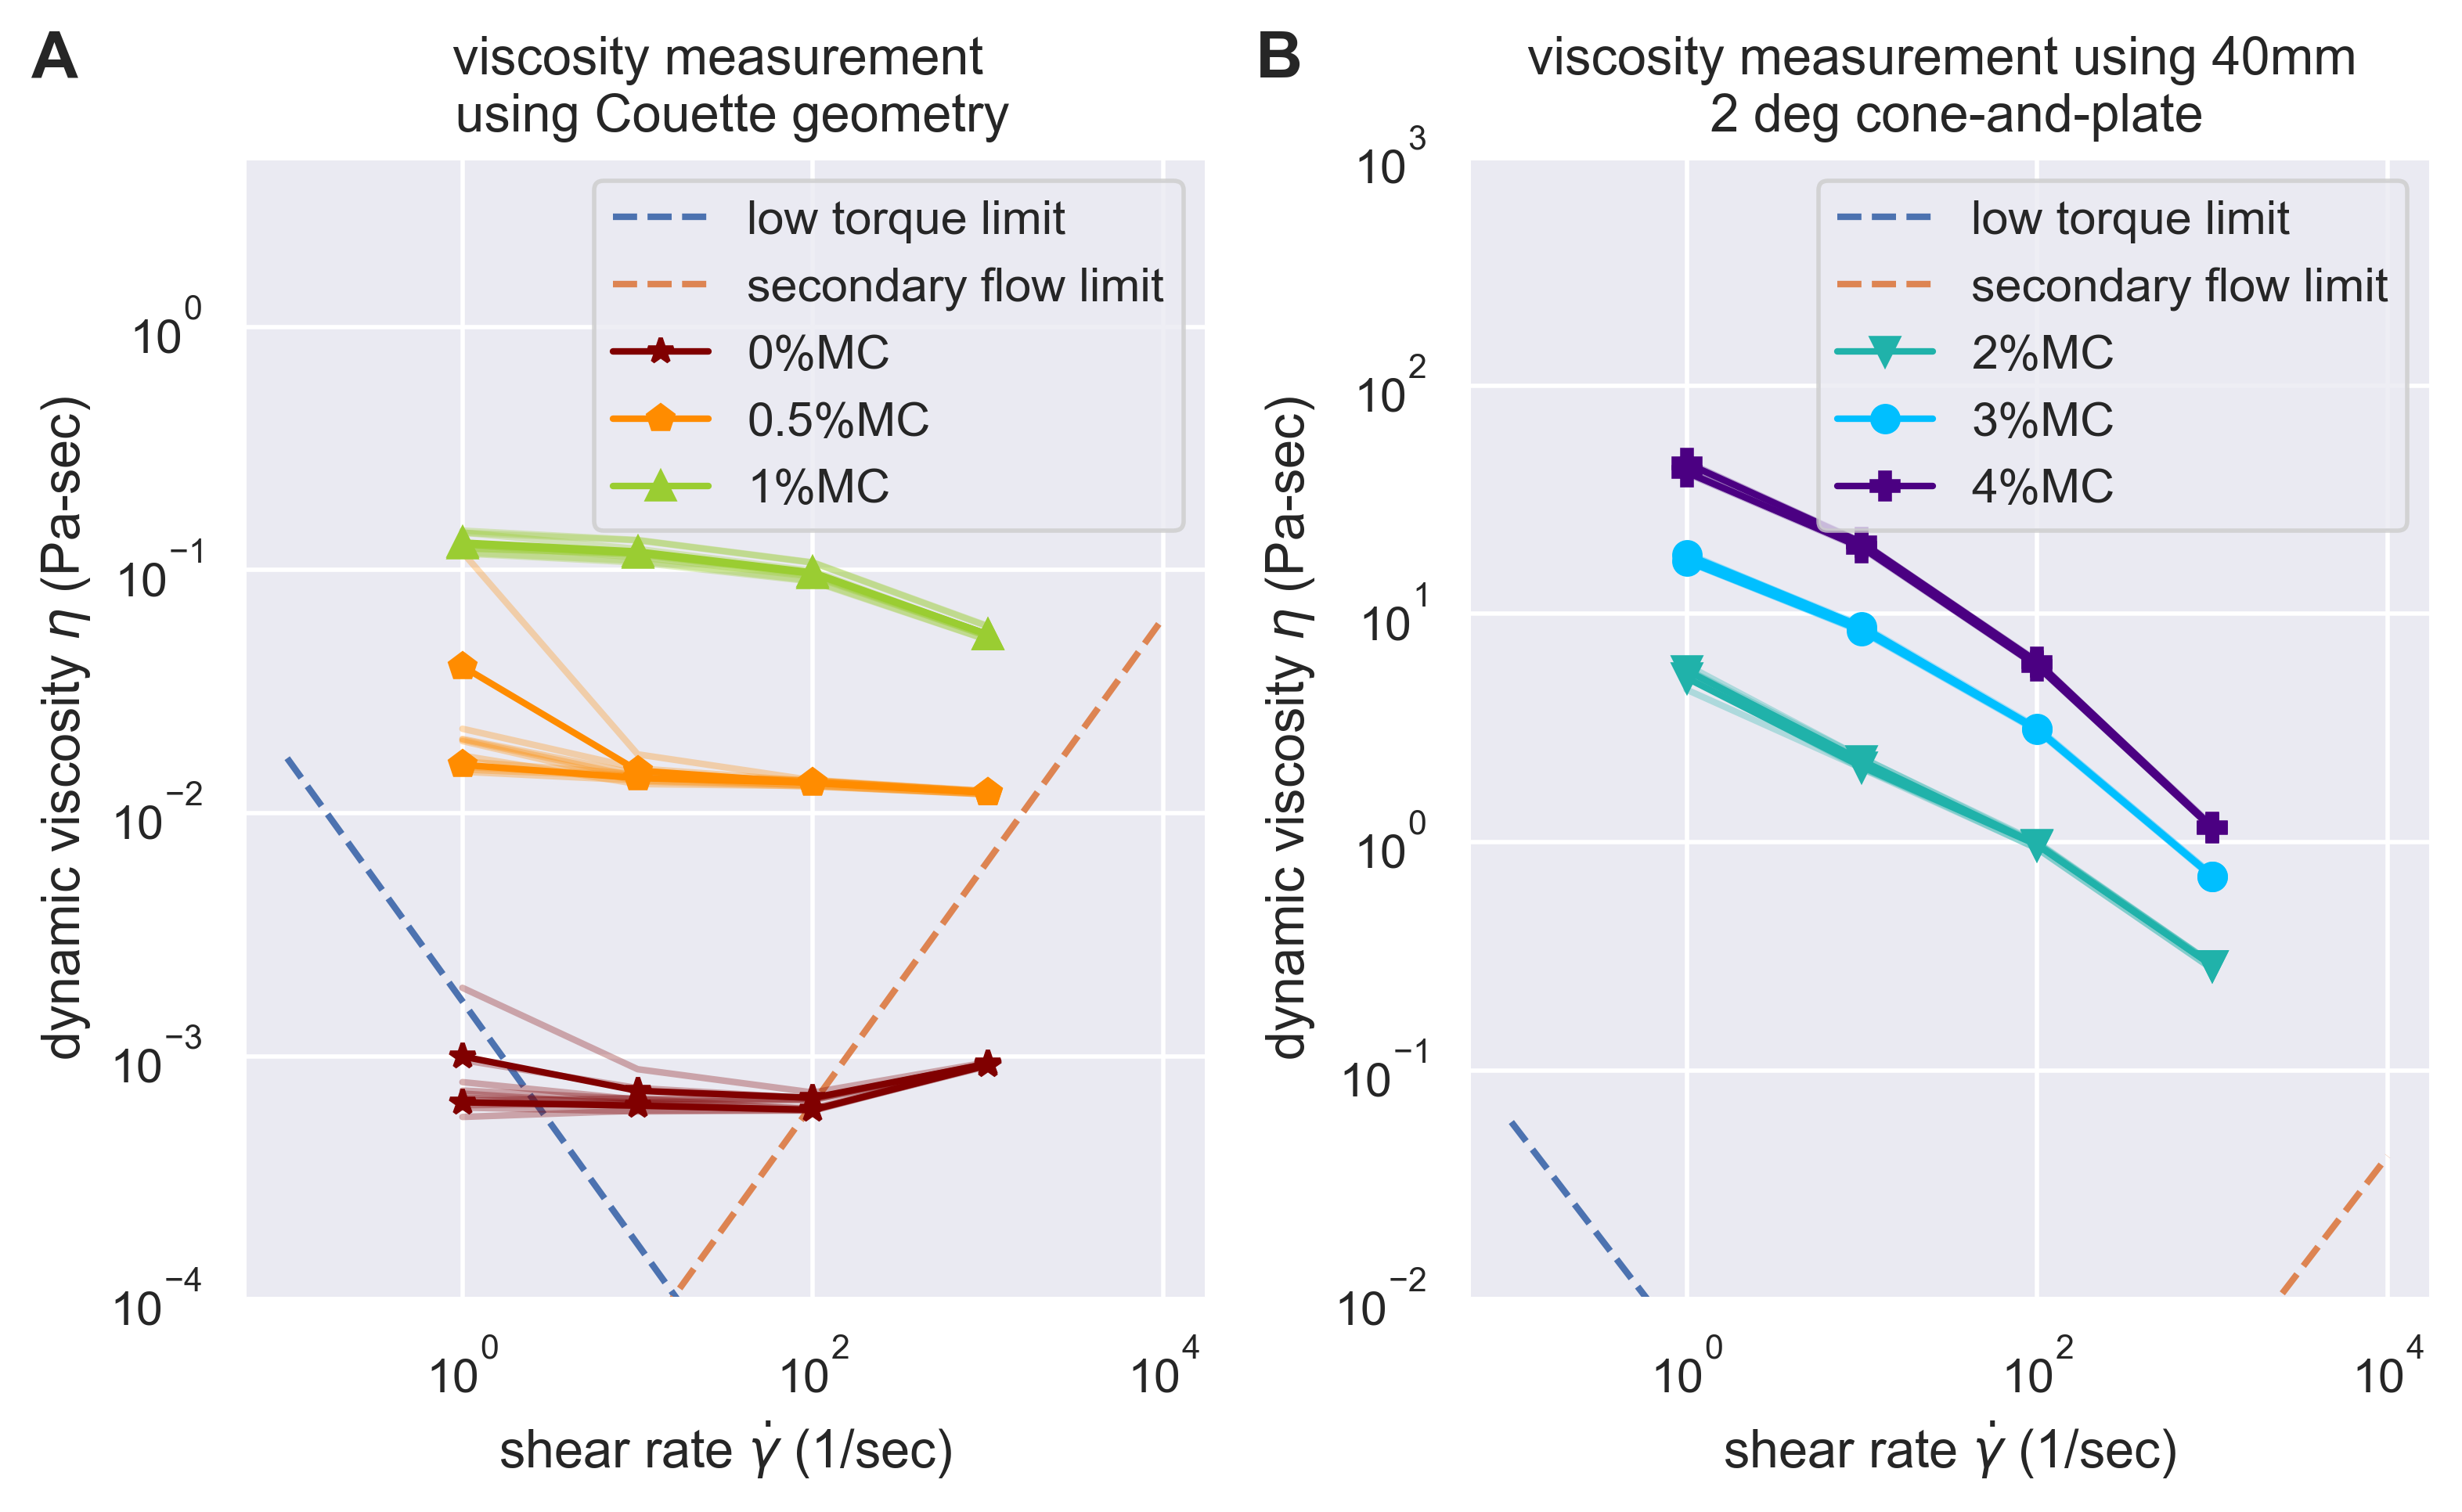

In [4]:
plt.figure(dpi = 400, figsize = (8,5))
sns.set_context("notebook")
plt.subplot(1,2,1)
plt.plot(shear_rate_range, F_tau_couette*T_min/shear_rate_range, label = 'low torque limit', linestyle = '--')
plt.plot(shear_rate_range, 2*rho*shear_rate_range*np.sqrt((Rc-Rb)**5*Rb)/(np.sqrt(3400)*(Rc+Rb)), label = 'secondary flow limit', linestyle = '--')
plt.plot(viscosity_data['shear_rate_fwd'], viscosity_data['0%']['mean_fwd'], marker = '*', label = '0%MC', color = 'maroon')
plt.plot(viscosity_data['shear_rate_bwd'], viscosity_data['0%']['mean_bwd'], marker = '*', color = 'maroon')
for (fwd, bwd) in zip(viscosity_data['0%']['raw_fwd'], viscosity_data['0%']['raw_bwd']):
    plt.plot(viscosity_data['shear_rate_fwd'], fwd, color = 'maroon', alpha = 0.3)
    plt.plot(viscosity_data['shear_rate_bwd'], bwd, color = 'maroon', alpha = 0.3)
plt.plot(viscosity_data['shear_rate_fwd'], viscosity_data['0.5%']['mean_fwd'], marker = 'p', label = '0.5%MC', color = 'darkorange')
plt.plot(viscosity_data['shear_rate_bwd'], viscosity_data['0.5%']['mean_bwd'], marker = 'p', color = 'darkorange')
for (fwd, bwd) in zip(viscosity_data['0.5%']['raw_fwd'], viscosity_data['0.5%']['raw_bwd']):
    plt.plot(viscosity_data['shear_rate_fwd'], fwd, color = 'darkorange', alpha = 0.3)
    plt.plot(viscosity_data['shear_rate_bwd'], bwd, color = 'darkorange', alpha = 0.3)
plt.plot(viscosity_data['shear_rate_fwd'], viscosity_data['1%']['mean_fwd'], marker = '^', label = '1%MC', color = 'yellowgreen')
plt.plot(viscosity_data['shear_rate_bwd'], viscosity_data['1%']['mean_bwd'], marker = '^', color = 'yellowgreen')
for (fwd, bwd) in zip(viscosity_data['1%']['raw_fwd'], viscosity_data['1%']['raw_bwd']):
    plt.plot(viscosity_data['shear_rate_fwd'], fwd, color = 'yellowgreen', alpha = 0.3)
    plt.plot(viscosity_data['shear_rate_bwd'], bwd, color = 'yellowgreen', alpha = 0.3)
plt.legend(loc='upper right')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1E-4,5])
plt.xlabel(r'shear rate $\dot{\gamma}$ (1/sec)')
plt.ylabel(r'dynamic viscosity $\eta$ (Pa-sec)')
plt.title('viscosity measurement \n using Couette geometry')
ax = plt.gca()
ax.text(-0.22, 1.07, string.ascii_uppercase[0], transform=ax.transAxes, 
            size=15, weight='bold')

plt.subplot(1,2,2)
plt.plot(shear_rate_range, F_tau*T_min/shear_rate_range, label = 'low torque limit', linestyle = '--')
plt.plot(shear_rate_range, rho*beta**3*R**2*shear_rate_range/Re_max, label = 'secondary flow limit', linestyle = '--')
plt.plot(viscosity_data['shear_rate_fwd'], viscosity_data['2%']['mean_fwd'], marker = 'v', label = '2%MC', color = 'lightseagreen')
plt.plot(viscosity_data['shear_rate_bwd'], viscosity_data['2%']['mean_bwd'], marker = 'v', color = 'lightseagreen')
for (fwd, bwd) in zip(viscosity_data['2%']['raw_fwd'], viscosity_data['2%']['raw_bwd']):
    plt.plot(viscosity_data['shear_rate_fwd'], fwd, color = 'lightseagreen', alpha = 0.3)
    plt.plot(viscosity_data['shear_rate_bwd'], bwd, color = 'lightseagreen', alpha = 0.3)
plt.plot(viscosity_data['shear_rate_fwd'], viscosity_data['3%']['mean_fwd'], marker = 'o', label = '3%MC', color = 'deepskyblue')
plt.plot(viscosity_data['shear_rate_bwd'], viscosity_data['3%']['mean_bwd'], marker = 'o', color = 'deepskyblue')
for (fwd, bwd) in zip(viscosity_data['3%']['raw_fwd'], viscosity_data['3%']['raw_bwd']):
    plt.plot(viscosity_data['shear_rate_fwd'], fwd, color = 'deepskyblue', alpha = 0.3)
    plt.plot(viscosity_data['shear_rate_bwd'], bwd, color = 'deepskyblue', alpha = 0.3)
plt.plot(viscosity_data['shear_rate_fwd'], viscosity_data['4%']['mean_fwd'], marker = 'P', label = '4%MC', color = 'indigo')
plt.plot(viscosity_data['shear_rate_bwd'], viscosity_data['4%']['mean_bwd'], marker = 'P', color = 'indigo')
for (fwd, bwd) in zip(viscosity_data['4%']['raw_fwd'], viscosity_data['4%']['raw_bwd']):
    plt.plot(viscosity_data['shear_rate_fwd'], fwd, color = 'indigo', alpha = 0.3)
    plt.plot(viscosity_data['shear_rate_bwd'], bwd, color = 'indigo', alpha = 0.3)
plt.legend(loc='upper right')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1E-2,1E3])
plt.xlabel(r'shear rate $\dot{\gamma}$ (1/sec)')
plt.ylabel(r'dynamic viscosity $\eta$ (Pa-sec)')
plt.title('viscosity measurement using 40mm \n 2 deg cone-and-plate')
ax = plt.gca()
ax.text(-0.22, 1.07, string.ascii_uppercase[1], transform=ax.transAxes, 
            size=15, weight='bold')
plt.tight_layout()
plt.savefig(output_path+'FigS3.png', bbox_inches='tight')
plt.show()

## Re-run the analysis on kinematics data

Here we set the parameters of cytoplasm viscosity and slip length just to use the function, but since we are only extracting kinematics data in Figure 3, which does not depend on the parameters we chose, so it does not matter. We will vary these parameters later on.

In [4]:
mu_0_percent = round((viscosity_data['0%']['mean_fwd'][1] + viscosity_data['0%']['mean_bwd'][2])/2, 5)
mu_05_percent = round((viscosity_data['0.5%']['mean_fwd'][-1] + viscosity_data['0.5%']['mean_bwd'][0])/2, 3)
mu_1_percent = round((viscosity_data['1%']['mean_fwd'][-1] + viscosity_data['1%']['mean_bwd'][0])/2, 3)
mu_2_percent = round((viscosity_data['2%']['mean_fwd'][-1] + viscosity_data['2%']['mean_bwd'][0])/2, 2)
mu_3_percent = round((viscosity_data['3%']['mean_fwd'][-1] + viscosity_data['3%']['mean_bwd'][0])/2, 2)
mu_4_percent = round((viscosity_data['4%']['mean_fwd'][-1] + viscosity_data['4%']['mean_bwd'][0])/2, 2)
print('viscosity of 0%MC = {} Pa-sec'.format(mu_0_percent))
print('viscosity of 0.5%MC = {} Pa-sec'.format(mu_05_percent))
print('viscosity of 1%MC = {} Pa-sec'.format(mu_1_percent))
print('viscosity of 2%MC = {} Pa-sec'.format(mu_2_percent))
print('viscosity of 3%MC = {} Pa-sec'.format(mu_3_percent))
print('viscosity of 4%MC = {} Pa-sec'.format(mu_4_percent))

viscosity of 0%MC = 0.00067 Pa-sec
viscosity of 0.5%MC = 0.012 Pa-sec
viscosity of 1%MC = 0.054 Pa-sec
viscosity of 2%MC = 0.29 Pa-sec
viscosity of 3%MC = 0.71 Pa-sec
viscosity of 4%MC = 1.16 Pa-sec


In [6]:
result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
save_pickle(result_0_percent, output_path + 'kinematics_result_0_percent')
save_pickle(result_05_percent, output_path + 'kinematics_result_0.5_percent')
save_pickle(result_1_percent, output_path + 'kinematics_result_1_percent')
save_pickle(result_2_percent, output_path + 'kinematics_result_2_percent')
save_pickle(result_3_percent, output_path + 'kinematics_result_3_percent')
save_pickle(result_4_percent, output_path + 'kinematics_result_4_percent')

## Fig 3

### if you did not re-run the above code, you need to load the saved pickle file

In [8]:
viscosity_data = pickle.load(open(data_path + "viscosity_data", "rb"))
result_0_percent = pickle.load(open(output_path + "kinematics_result_0_percent", "rb"))
result_05_percent = pickle.load(open(output_path + "kinematics_result_0.5_percent", "rb"))
result_1_percent = pickle.load(open(output_path + "kinematics_result_1_percent", "rb"))
result_2_percent = pickle.load(open(output_path + "kinematics_result_2_percent", "rb"))
result_3_percent = pickle.load(open(output_path + "kinematics_result_3_percent", "rb"))
result_4_percent = pickle.load(open(output_path + "kinematics_result_4_percent", "rb"))

### plot Fig 3

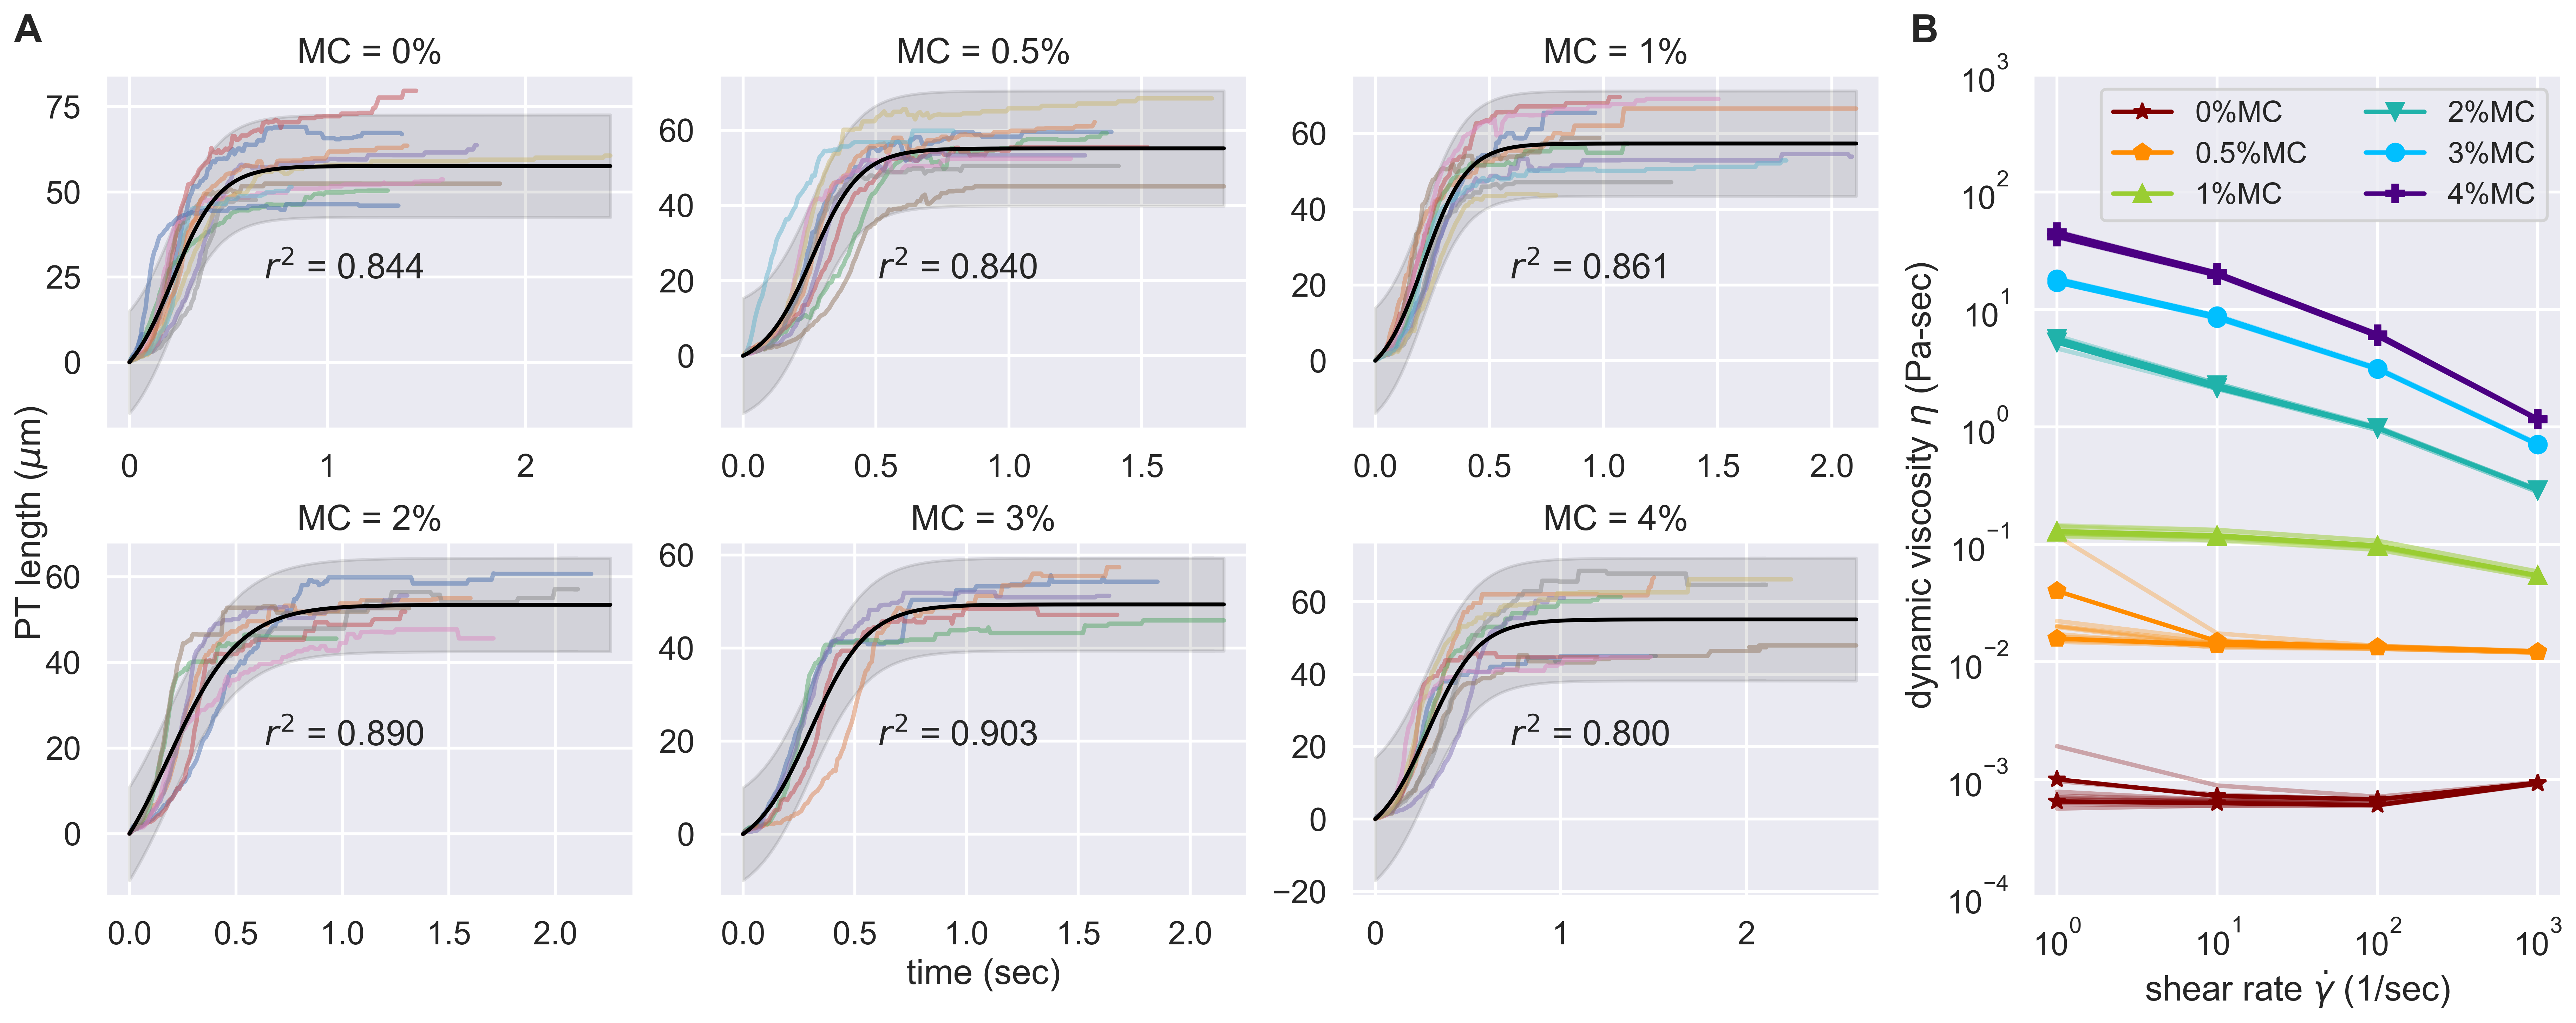

In [9]:
sns.set_context('talk')
fig = plt.figure(constrained_layout=True, tight_layout=False, dpi = 400, figsize = (18,7))
gs = fig.add_gridspec(2, 4)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('MC = 0%')
ax = ax1; result = result_0_percent
for label, content in result['df_L'].items():
    ax.plot(result['time'], content, alpha = 0.5)
ax.plot(result['time'], sigmoid(result['time'], *result['popt']), color = 'black', linewidth = 2)
ax.fill_between(result['time'], result['upb'], result['lpb'], color = 'black', alpha = 0.1)
ax.text(0.3, 0.5, r'$r^2$'+' = {:.3f}'.format(result['r2']), horizontalalignment='left',verticalalignment='top',transform=plt.gca().transAxes)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('MC = 0.5%')
ax = ax2; result = result_05_percent
for label, content in result['df_L'].items():
    ax.plot(result['time'], content, alpha = 0.5)
ax.plot(result['time'], sigmoid(result['time'], *result['popt']), color = 'black', linewidth = 2)
ax.fill_between(result['time'], result['upb'], result['lpb'], color = 'black', alpha = 0.1)
ax.text(0.3, 0.5, r'$r^2$'+' = {:.3f}'.format(result['r2']), horizontalalignment='left',verticalalignment='top',transform=plt.gca().transAxes)

ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title('MC = 1%')
ax = ax3; result = result_1_percent
for label, content in result['df_L'].items():
    ax.plot(result['time'], content, alpha = 0.5)
ax.plot(result['time'], sigmoid(result['time'], *result['popt']), color = 'black', linewidth = 2)
ax.fill_between(result['time'], result['upb'], result['lpb'], color = 'black', alpha = 0.1)
ax.text(0.3, 0.5, r'$r^2$'+' = {:.3f}'.format(result['r2']), horizontalalignment='left',verticalalignment='top',transform=plt.gca().transAxes)

ax4 = fig.add_subplot(gs[1, 0])
ax4.set_title('MC = 2%')
ax = ax4; result = result_2_percent
for label, content in result['df_L'].items():
    ax.plot(result['time'], content, alpha = 0.5)
ax.plot(result['time'], sigmoid(result['time'], *result['popt']), color = 'black', linewidth = 2)
ax.fill_between(result['time'], result['upb'], result['lpb'], color = 'black', alpha = 0.1)
ax.text(0.3, 0.5, r'$r^2$'+' = {:.3f}'.format(result['r2']), horizontalalignment='left',verticalalignment='top',transform=plt.gca().transAxes)

ax5 = fig.add_subplot(gs[1, 1])
ax5.set_title('MC = 3%')
ax = ax5; result = result_3_percent
for label, content in result['df_L'].items():
    ax.plot(result['time'], content, alpha = 0.5)
ax.plot(result['time'], sigmoid(result['time'], *result['popt']), color = 'black', linewidth = 2)
ax.fill_between(result['time'], result['upb'], result['lpb'], color = 'black', alpha = 0.1)
ax.text(0.3, 0.5, r'$r^2$'+' = {:.3f}'.format(result['r2']), horizontalalignment='left',verticalalignment='top',transform=plt.gca().transAxes)
ax5.set_xlabel('time (sec)')

ax6 = fig.add_subplot(gs[1, 2])
ax6.set_title('MC = 4%')
ax = ax6; result = result_4_percent
for label, content in result['df_L'].items():
    ax.plot(result['time'], content, alpha = 0.5)
ax.plot(result['time'], sigmoid(result['time'], *result['popt']), color = 'black', linewidth = 2)
ax.fill_between(result['time'], result['upb'], result['lpb'], color = 'black', alpha = 0.1)
ax.text(0.3, 0.5, r'$r^2$'+' = {:.3f}'.format(result['r2']), horizontalalignment='left',verticalalignment='top',transform=plt.gca().transAxes)

ax7 = fig.add_subplot(gs[:, 3])
ax7.plot(viscosity_data['shear_rate_fwd'], viscosity_data['0%']['mean_fwd'], marker = '*', label = '0%MC', color = 'maroon')
ax7.plot(viscosity_data['shear_rate_bwd'], viscosity_data['0%']['mean_bwd'], marker = '*', color = 'maroon')
for (fwd, bwd) in zip(viscosity_data['0%']['raw_fwd'], viscosity_data['0%']['raw_bwd']):
    ax7.plot(viscosity_data['shear_rate_fwd'], fwd, color = 'maroon', alpha = 0.3)
    ax7.plot(viscosity_data['shear_rate_bwd'], bwd, color = 'maroon', alpha = 0.3)
ax7.plot(viscosity_data['shear_rate_fwd'], viscosity_data['0.5%']['mean_fwd'], marker = 'p', label = '0.5%MC', color = 'darkorange')
ax7.plot(viscosity_data['shear_rate_bwd'], viscosity_data['0.5%']['mean_bwd'], marker = 'p', color = 'darkorange')
for (fwd, bwd) in zip(viscosity_data['0.5%']['raw_fwd'], viscosity_data['0.5%']['raw_bwd']):
    ax7.plot(viscosity_data['shear_rate_fwd'], fwd, color = 'darkorange', alpha = 0.3)
    ax7.plot(viscosity_data['shear_rate_bwd'], bwd, color = 'darkorange', alpha = 0.3)
ax7.plot(viscosity_data['shear_rate_fwd'], viscosity_data['1%']['mean_fwd'], marker = '^', label = '1%MC', color = 'yellowgreen')
ax7.plot(viscosity_data['shear_rate_bwd'], viscosity_data['1%']['mean_bwd'], marker = '^', color = 'yellowgreen')
for (fwd, bwd) in zip(viscosity_data['1%']['raw_fwd'], viscosity_data['1%']['raw_bwd']):
    ax7.plot(viscosity_data['shear_rate_fwd'], fwd, color = 'yellowgreen', alpha = 0.3)
    ax7.plot(viscosity_data['shear_rate_bwd'], bwd, color = 'yellowgreen', alpha = 0.3)
ax7.plot(viscosity_data['shear_rate_fwd'], viscosity_data['2%']['mean_fwd'], marker = 'v', label = '2%MC', color = 'lightseagreen')
ax7.plot(viscosity_data['shear_rate_bwd'], viscosity_data['2%']['mean_bwd'], marker = 'v', color = 'lightseagreen')
for (fwd, bwd) in zip(viscosity_data['2%']['raw_fwd'], viscosity_data['2%']['raw_bwd']):
    ax7.plot(viscosity_data['shear_rate_fwd'], fwd, color = 'lightseagreen', alpha = 0.3)
    ax7.plot(viscosity_data['shear_rate_bwd'], bwd, color = 'lightseagreen', alpha = 0.3)
ax7.plot(viscosity_data['shear_rate_fwd'], viscosity_data['3%']['mean_fwd'], marker = 'o', label = '3%MC', color = 'deepskyblue')
ax7.plot(viscosity_data['shear_rate_bwd'], viscosity_data['3%']['mean_bwd'], marker = 'o', color = 'deepskyblue')
for (fwd, bwd) in zip(viscosity_data['3%']['raw_fwd'], viscosity_data['3%']['raw_bwd']):
    ax7.plot(viscosity_data['shear_rate_fwd'], fwd, color = 'deepskyblue', alpha = 0.3)
    ax7.plot(viscosity_data['shear_rate_bwd'], bwd, color = 'deepskyblue', alpha = 0.3)
ax7.plot(viscosity_data['shear_rate_fwd'], viscosity_data['4%']['mean_fwd'], marker = 'P', label = '4%MC', color = 'indigo')
ax7.plot(viscosity_data['shear_rate_bwd'], viscosity_data['4%']['mean_bwd'], marker = 'P', color = 'indigo')
for (fwd, bwd) in zip(viscosity_data['4%']['raw_fwd'], viscosity_data['4%']['raw_bwd']):
    ax7.plot(viscosity_data['shear_rate_fwd'], fwd, color = 'indigo', alpha = 0.3)
    ax7.plot(viscosity_data['shear_rate_bwd'], bwd, color = 'indigo', alpha = 0.3)
ax7.legend(loc='best', ncol=2, fontsize = 15)
ax7.set_xscale('log')
ax7.set_yscale('log')
ax7.set_ylim([1E-4,1E3])
ax7.set_xlabel(r'shear rate $\dot{\gamma}$ (1/sec)')
ax7.set_ylabel(r'dynamic viscosity $\eta$ (Pa-sec)')
fig.text(-0.01, 0.5, r'PT length ($\mu$m)', va='center', rotation='vertical')
fig.text(-0.01, 1, 'A', fontweight = 'bold', va='center', fontsize = 20)
fig.text(0.74, 1, 'B', fontweight = 'bold', va='center', fontsize = 20)
plt.savefig(output_path+'Fig3.png', bbox_inches='tight')
plt.show()

## Fig 4

#### Note that in all the following, these abbreviations were used for the models mentioned in the paper
FTM = H-NOE-PTS-ExP

TMC = E-NOE-PTCN-ExP

TMO = E-OE-PTS-ExP

TME = E-OE-PTN-ExP

TMEP = E-OE-PTPV-ExP

In [27]:
# cytoplasmic viscosity = 0.05Pa-sec, slip length = 0 nm.
mu_cyto = 0.05
result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent, mu_cyto = mu_cyto, delta = 0)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent, mu_cyto = mu_cyto, delta = 0)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent, mu_cyto = mu_cyto, delta = 0)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent, mu_cyto = mu_cyto, delta = 0)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent, mu_cyto = mu_cyto, delta = 0)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent, mu_cyto = mu_cyto, delta = 0)
result_summarized_mucyto5EN2 = summary_statistics_and_plot(result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent)
result = result_summarized_mucyto5EN2
for method in ['ANOVA', 'Kruskal']:
    print(method + ':')
    for keys in ['FTM', 'TMC', 'TMO', 'TME', 'TMEP']:
        print('--'+keys+' :')
        for items in ['stat_E', 'stat_P', 'stat_W']:
            print('----'+items +', pvalue = '+ str(result[items][keys][method].pvalue))
save_pickle(result_summarized_mucyto5EN2, output_path + 'result_summarized_mucyto5EN2')

ANOVA:
--FTM :
----stat_E, pvalue = 1.1652753075466701e-14
----stat_P, pvalue = 0.0006369238281670931
----stat_W, pvalue = 4.416582557175699e-11
--TMC :
----stat_E, pvalue = 0.19117014251750453
----stat_P, pvalue = 0.6243398224068215
----stat_W, pvalue = 0.5842252856446282
--TMO :
----stat_E, pvalue = 0.0726466298520917
----stat_P, pvalue = 0.05692105902132821
----stat_W, pvalue = 0.11000158503415469
--TME :
----stat_E, pvalue = 0.13363080716855172
----stat_P, pvalue = 0.11067338562892544
----stat_W, pvalue = 0.2730602776872601
--TMEP :
----stat_E, pvalue = 0.2776120231453392
----stat_P, pvalue = 0.40641624061001763
----stat_W, pvalue = 0.7213608382278793
Kruskal:
--FTM :
----stat_E, pvalue = 1.6870354981661338e-06
----stat_P, pvalue = 0.013111976659173788
----stat_W, pvalue = 4.81667995955978e-05
--TMC :
----stat_E, pvalue = 0.14777424722767746
----stat_P, pvalue = 0.6597420911402108
----stat_W, pvalue = 0.7143084852490004
--TMO :
----stat_E, pvalue = 0.05266164404105797
----stat_P, p

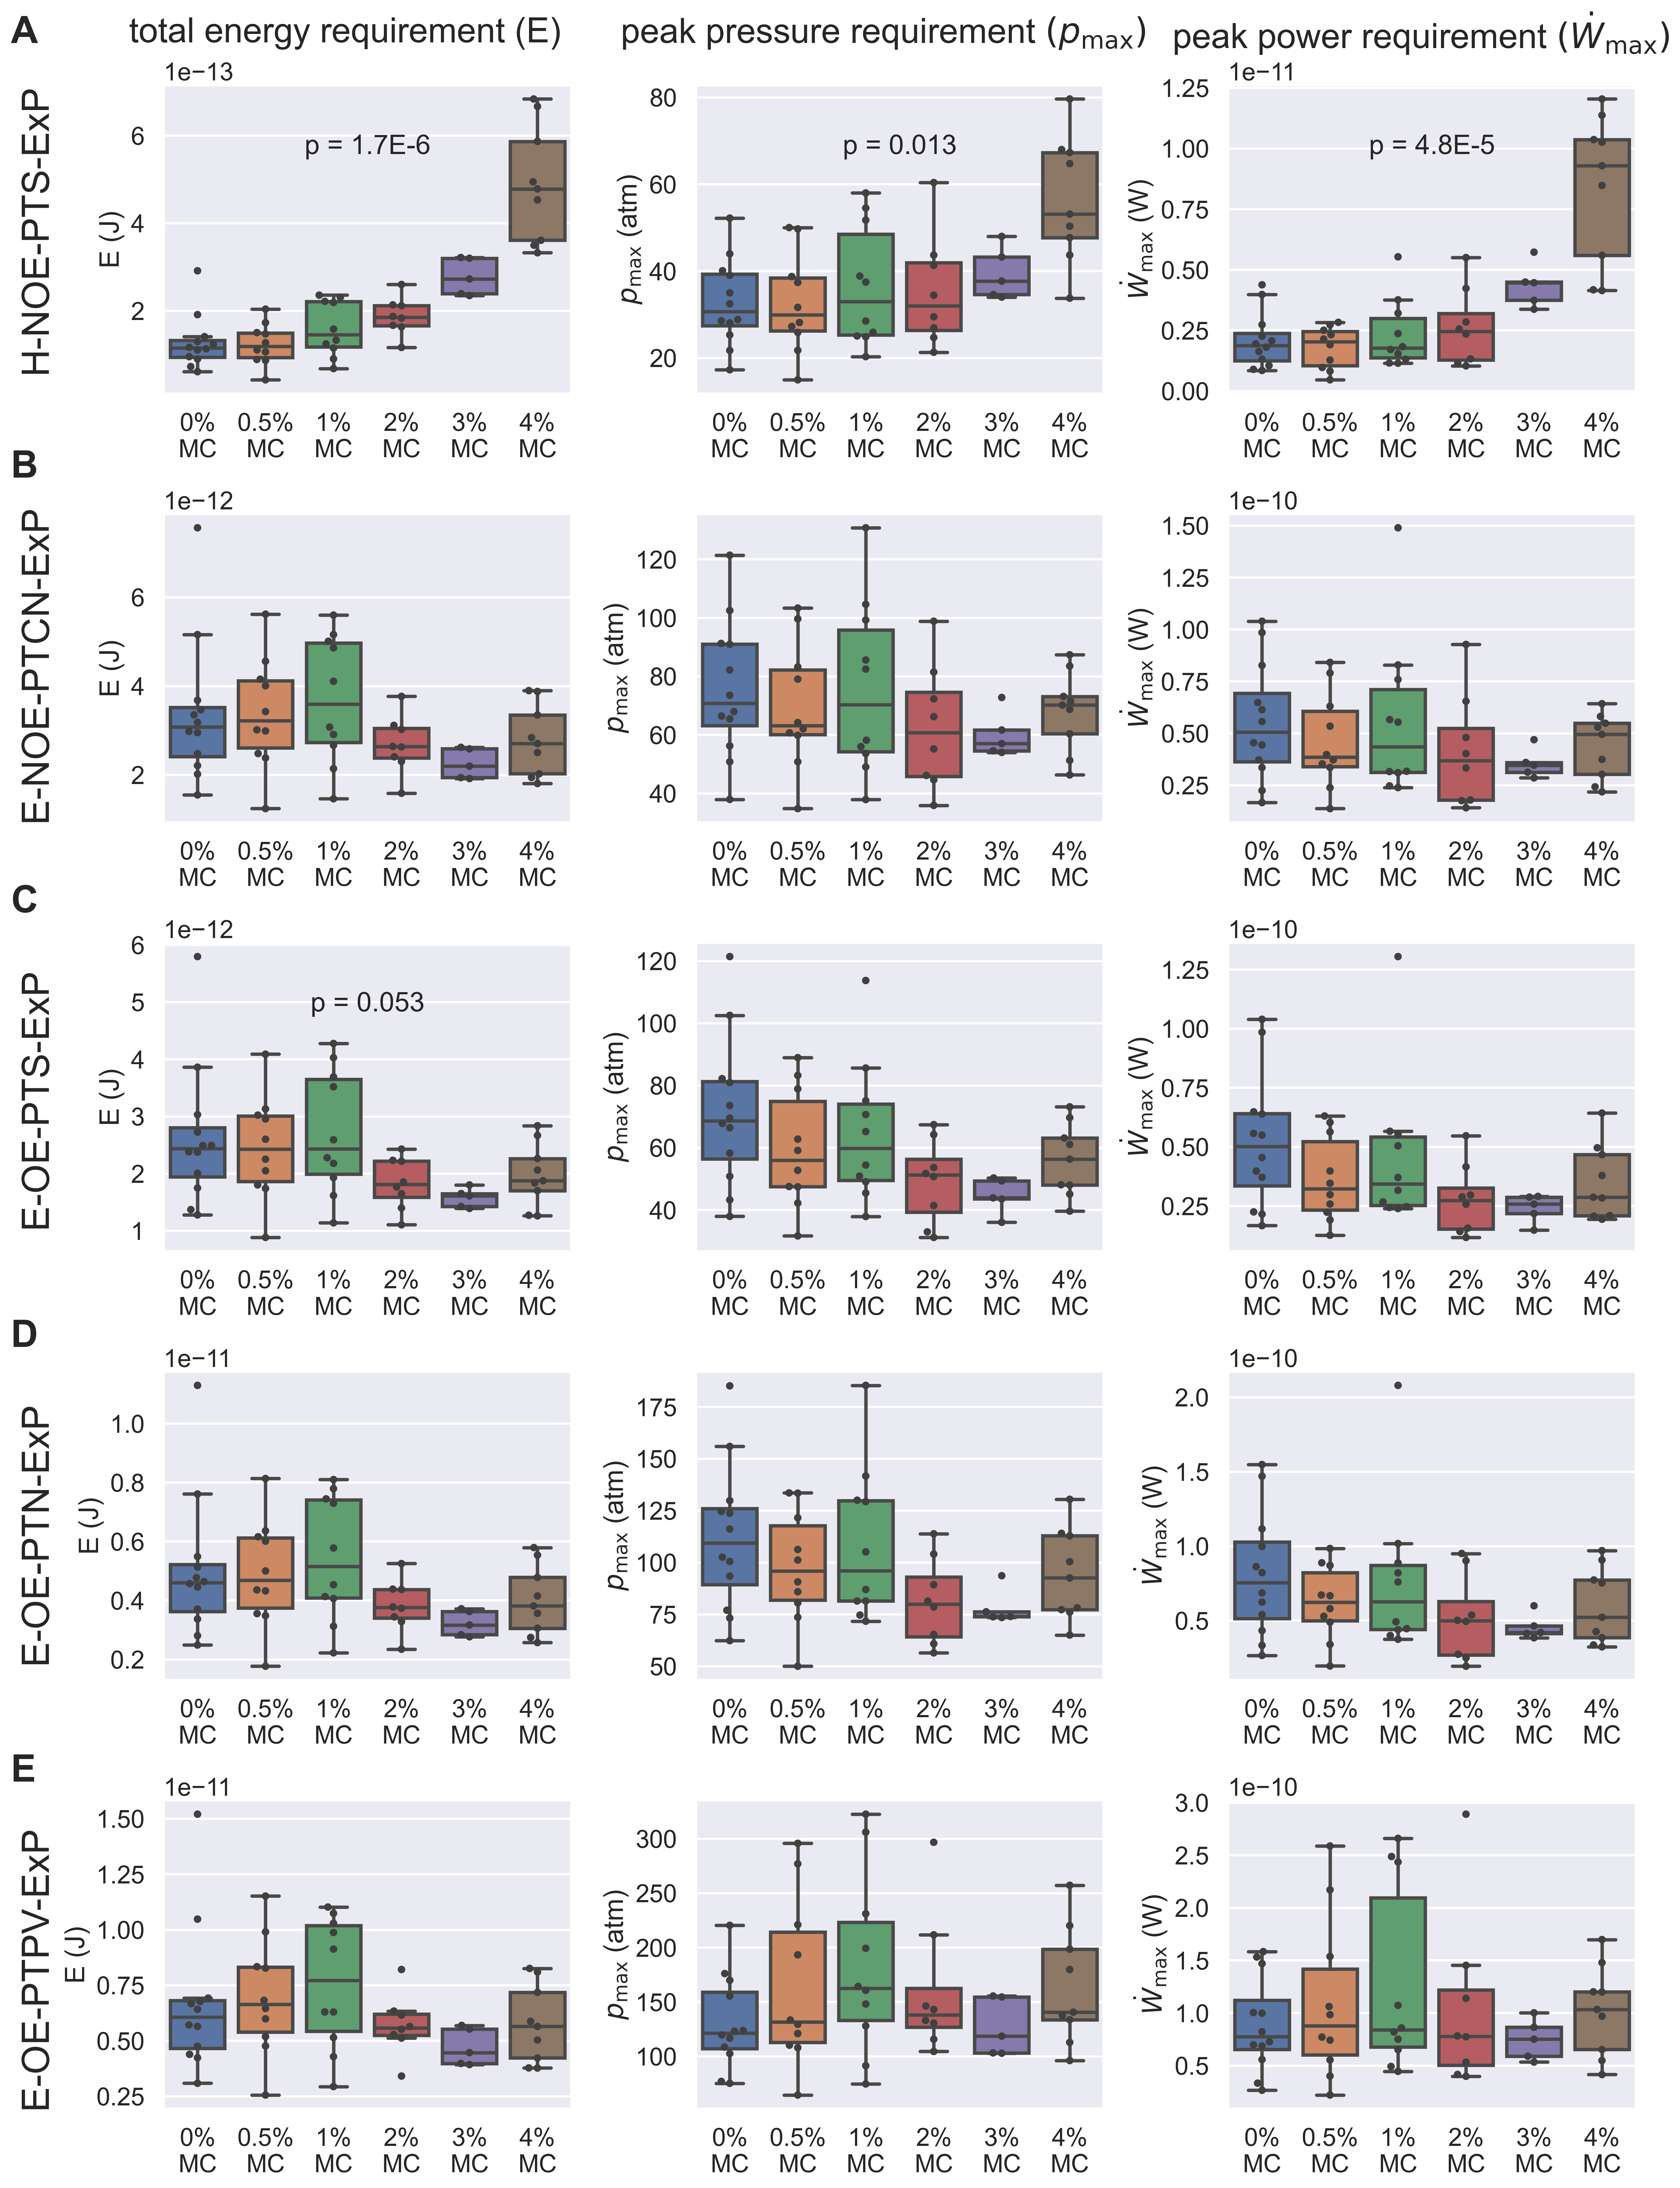

In [31]:
text = ['0%\nMC', '0.5%\nMC', '1%\nMC', '2%\nMC', '3%\nMC', '4%\nMC']
sns.set_context('talk')
fig = plt.figure(dpi = 400, figsize = (15,20))

# FTM/H-NOE-PTS-ExP
plt.subplot(5,3,1)
sns.boxplot(data = result['E_FTM_all'], showfliers = False)
sns.swarmplot(data = result['E_FTM_all'], color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.text(0.5, 0.8, 'p = 1.7E-6', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes)
plt.ylabel('E (J)')
plt.subplot(5,3,2)
p_atm = [[xj/101325 for xj in xi] for xi in result['P_peak_FTM_all']]
sns.boxplot(data = p_atm, showfliers = False)
sns.swarmplot(data = p_atm, color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.text(0.5, 0.8, 'p = 0.013', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes)
plt.ylabel(r'$p_{\mathrm{max}}$'+' (atm)')
plt.subplot(5,3,3)
sns.boxplot(data = result['W_peak_FTM_all'], showfliers = False)
sns.swarmplot(data = result['W_peak_FTM_all'], color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.text(0.5, 0.8, 'p = 4.8E-5', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes)
plt.ylabel(r'$\dot{W}_{\mathrm{max}}$'+' (W)')

# TMC/E-NOE-PTCN-ExP
plt.subplot(5,3,4)
sns.boxplot(data = result['E_TMC_all'], showfliers = False)
sns.swarmplot(data = result['E_TMC_all'], color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.ylabel('E (J)')
plt.subplot(5,3,5)
p_atm = [[xj/101325 for xj in xi] for xi in result['P_peak_TMC_all']]
sns.boxplot(data = p_atm, showfliers = False)
sns.swarmplot(data = p_atm, color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.ylabel(r'$p_{\mathrm{max}}$'+' (atm)')
plt.subplot(5,3,6)
sns.boxplot(data = result['W_peak_TMC_all'], showfliers = False)
sns.swarmplot(data = result['W_peak_TMC_all'], color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.ylabel(r'$\dot{W}_{\mathrm{max}}$'+' (W)')

# TMO/E-OE-PTS-ExP
plt.subplot(5,3,7)
sns.boxplot(data = result['E_TMO_all'], showfliers = False)
sns.swarmplot(data = result['E_TMO_all'], color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.text(0.5, 0.8, 'p = 0.053', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes)
plt.ylabel('E (J)')
plt.subplot(5,3,8)
p_atm = [[xj/101325 for xj in xi] for xi in result['P_peak_TMO_all']]
sns.boxplot(data = p_atm, showfliers = False)
sns.swarmplot(data = p_atm, color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.ylabel(r'$p_{\mathrm{max}}$'+' (atm)')
plt.subplot(5,3,9)
sns.boxplot(data = result['W_peak_TMO_all'], showfliers = False)
sns.swarmplot(data = result['W_peak_TMO_all'], color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.ylabel(r'$\dot{W}_{\mathrm{max}}$'+' (W)')

# TME/E-OE-PTN-ExP
plt.subplot(5,3,10)
sns.boxplot(data = result['E_TME_all'], showfliers = False)
sns.swarmplot(data = result['E_TME_all'], color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.ylabel('E (J)')
plt.subplot(5,3,11)
p_atm = [[xj/101325 for xj in xi] for xi in result['P_peak_TME_all']]
sns.boxplot(data = p_atm, showfliers = False)
sns.swarmplot(data = p_atm, color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.ylabel(r'$p_{\mathrm{max}}$'+' (atm)')
plt.subplot(5,3,12)
sns.boxplot(data = result['W_peak_TME_all'], showfliers = False)
sns.swarmplot(data = result['W_peak_TME_all'], color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.ylabel(r'$\dot{W}_{\mathrm{max}}$'+' (W)')

# TMEP/E-OE-PTPV-ExP
plt.subplot(5,3,13)
sns.boxplot(data = result['E_TMEP_all'], showfliers = False)
sns.swarmplot(data = result['E_TMEP_all'], color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.ylabel('E (J)')
plt.subplot(5,3,14)
p_atm = [[xj/101325 for xj in xi] for xi in result['P_peak_TMEP_all']]
sns.boxplot(data = p_atm, showfliers = False)
sns.swarmplot(data = p_atm, color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.ylabel(r'$p_{\mathrm{max}}$'+' (atm)')
plt.subplot(5,3,15)
sns.boxplot(data = result['W_peak_TMEP_all'], showfliers = False)
sns.swarmplot(data = result['W_peak_TMEP_all'], color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.ylabel(r'$\dot{W}_{\mathrm{max}}$'+' (W)')

plt.tight_layout()
fig.text(0.19, 1, 'total energy requirement (E)', ha = 'center', va='center', fontsize = 23)
fig.text(0.52, 1, 'peak pressure requirement '+r'$(p_{\mathrm{max}})$', ha = 'center', va='center', fontsize = 23)
fig.text(0.85, 1, 'peak power requirement '+r'$(\dot{W}_{\mathrm{max}})$', ha = 'center', va='center', fontsize = 23)
fig.text(-0.01, 0.9+0.01, 'H-NOE-PTS-ExP', rotation = 90, va='center', fontsize = 25)
fig.text(-0.01, 0.7+0.01, 'E-NOE-PTCN-ExP', rotation = 90, va='center', fontsize = 25)
fig.text(-0.01, 0.5+0.01, 'E-OE-PTS-ExP', rotation = 90, va='center', fontsize = 25)
fig.text(-0.01, 0.3+0.01, 'E-OE-PTN-ExP', rotation = 90, va='center', fontsize = 25)
fig.text(-0.01, 0.1+0.01, 'E-OE-PTPV-ExP', rotation = 90, va='center', fontsize = 25)
fig.text(-0.015, 1.0-0.0, 'A', fontweight = 'bold', va='center', fontsize = 25)
fig.text(-0.015, 0.8-0.0, 'B', fontweight = 'bold', va='center', fontsize = 25)
fig.text(-0.015, 0.6-0.0, 'C', fontweight = 'bold', va='center', fontsize = 25)
fig.text(-0.015, 0.4-0.0, 'D', fontweight = 'bold', va='center', fontsize = 25)
fig.text(-0.015, 0.2-0.0, 'E', fontweight = 'bold', va='center', fontsize = 25)

plt.savefig(output_path+'Fig4_highRes.png', bbox_inches='tight', dpi = 400)
plt.savefig(output_path+'Fig4_lowRes.png', bbox_inches='tight', dpi = 150)
plt.show()

## Table 1

In [24]:
# cytoplasmic viscosity = 0.001Pa-sec, slip length = 0 nm.
result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent, mu_cyto = 0.001, delta = 0)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent, mu_cyto = 0.001, delta = 0)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent, mu_cyto = 0.001, delta = 0)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent, mu_cyto = 0.001, delta = 0)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent, mu_cyto = 0.001, delta = 0)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent, mu_cyto = 0.001, delta = 0)
result_summarized_mucyto1EN3 = summary_statistics_and_plot(result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent)
result = result_summarized_mucyto1EN3
for method in ['ANOVA', 'Kruskal']:
    print(method + ':')
    for keys in ['FTM', 'TMC', 'TMO', 'TME', 'TMEP']:
        print('--'+keys+' :')
        for items in ['stat_E', 'stat_P', 'stat_W']:
            print('----'+items +', pvalue = '+ str(result[items][keys][method].pvalue))
save_pickle(result_summarized_mucyto1EN3, output_path + 'result_summarized_mucyto1EN3')

ANOVA:
--FTM :
----stat_E, pvalue = 9.550982447878205e-25
----stat_P, pvalue = 3.689021239497061e-22
----stat_W, pvalue = 1.7756806405292586e-16
--TMC :
----stat_E, pvalue = 0.288964575509639
----stat_P, pvalue = 0.7671294848463176
----stat_W, pvalue = 0.6688841321131672
--TMO :
----stat_E, pvalue = 0.14409185701072774
----stat_P, pvalue = 0.14439849077071254
----stat_W, pvalue = 0.146796529543645
--TME :
----stat_E, pvalue = 0.18490633679120427
----stat_P, pvalue = 0.19953323020667435
----stat_W, pvalue = 0.3224622501361334
--TMEP :
----stat_E, pvalue = 0.33277001663264955
----stat_P, pvalue = 0.3933659079792999
----stat_W, pvalue = 0.733731493115414
Kruskal:
--FTM :
----stat_E, pvalue = 9.909301943078731e-10
----stat_P, pvalue = 4.256863723454487e-09
----stat_W, pvalue = 3.1899197431237592e-09
--TMC :
----stat_E, pvalue = 0.24128494864276254
----stat_P, pvalue = 0.7882792476850767
----stat_W, pvalue = 0.8073772533548182
--TMO :
----stat_E, pvalue = 0.1214639630635283
----stat_P, pval

In [25]:
# cytoplasmic viscosity = 0.8Pa-sec, slip length = 0 nm.
result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent, mu_cyto = 0.8, delta = 0)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent, mu_cyto = 0.8, delta = 0)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent, mu_cyto = 0.8, delta = 0)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent, mu_cyto = 0.8, delta = 0)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent, mu_cyto = 0.8, delta = 0)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent, mu_cyto = 0.8, delta = 0)
result_summarized_mucyto8EN1 = summary_statistics_and_plot(result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent)
result = result_summarized_mucyto8EN1
for method in ['ANOVA', 'Kruskal']:
    print(method + ':')
    for keys in ['FTM', 'TMC', 'TMO', 'TME', 'TMEP']:
        print('--'+keys+' :')
        for items in ['stat_E', 'stat_P', 'stat_W']:
            print('----'+items +', pvalue = '+ str(result[items][keys][method].pvalue))
save_pickle(result_summarized_mucyto8EN1, output_path + 'result_summarized_mucyto8EN1')

ANOVA:
--FTM :
----stat_E, pvalue = 0.26367631990070467
----stat_P, pvalue = 0.7748835401097088
----stat_W, pvalue = 0.28953441903470484
--TMC :
----stat_E, pvalue = 0.18945813238085876
----stat_P, pvalue = 0.6184338921204973
----stat_W, pvalue = 0.582427739981084
--TMO :
----stat_E, pvalue = 0.07156539021917475
----stat_P, pvalue = 0.055468002800892396
----stat_W, pvalue = 0.10932724028734729
--TME :
----stat_E, pvalue = 0.1327365333034819
----stat_P, pvalue = 0.10899447124222221
----stat_W, pvalue = 0.27210973636437874
--TMEP :
----stat_E, pvalue = 0.27658032040087766
----stat_P, pvalue = 0.4064078632517198
----stat_W, pvalue = 0.7210893010745423
Kruskal:
--FTM :
----stat_E, pvalue = 0.19999117586458792
----stat_P, pvalue = 0.8072982182500286
----stat_W, pvalue = 0.3297420608158321
--TMC :
----stat_E, pvalue = 0.14777424722767746
----stat_P, pvalue = 0.6597420911402108
----stat_W, pvalue = 0.7143084852490004
--TMO :
----stat_E, pvalue = 0.05266164404105797
----stat_P, pvalue = 0.0777

In [26]:
# cytoplasmic viscosity = 10Pa-sec, slip length = 0 nm.
result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent, mu_cyto = 10, delta = 0)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent, mu_cyto = 10, delta = 0)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent, mu_cyto = 10, delta = 0)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent, mu_cyto = 10, delta = 0)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent, mu_cyto = 10, delta = 0)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent, mu_cyto = 10, delta = 0)
result_summarized_mucyto1E1 = summary_statistics_and_plot(result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent)
result = result_summarized_mucyto1E1
for method in ['ANOVA', 'Kruskal']:
    print(method + ':')
    for keys in ['FTM', 'TMC', 'TMO', 'TME', 'TMEP']:
        print('--'+keys+' :')
        for items in ['stat_E', 'stat_P', 'stat_W']:
            print('----'+items +', pvalue = '+ str(result[items][keys][method].pvalue))
save_pickle(result_summarized_mucyto1E1, output_path + 'result_summarized_mucyto1E1')

ANOVA:
--FTM :
----stat_E, pvalue = 0.07056315552366278
----stat_P, pvalue = 0.7126638854686576
----stat_W, pvalue = 0.16758164442453236
--TMC :
----stat_E, pvalue = 0.18935337435152852
----stat_P, pvalue = 0.6180683297343816
----stat_W, pvalue = 0.5823173008341965
--TMO :
----stat_E, pvalue = 0.07149943592555756
----stat_P, pvalue = 0.05537956123009121
----stat_W, pvalue = 0.10928593016651061
--TME :
----stat_E, pvalue = 0.13268179833280738
----stat_P, pvalue = 0.10889178243110809
----stat_W, pvalue = 0.27205144079353427
--TMEP :
----stat_E, pvalue = 0.27651708027970107
----stat_P, pvalue = 0.4064070280204496
----stat_W, pvalue = 0.7210726040445785
Kruskal:
--FTM :
----stat_E, pvalue = 0.048275040898249806
----stat_P, pvalue = 0.7810702263314462
----stat_W, pvalue = 0.15665859706626542
--TMC :
----stat_E, pvalue = 0.14777424722767746
----stat_P, pvalue = 0.6597420911402108
----stat_W, pvalue = 0.7143084852490004
--TMO :
----stat_E, pvalue = 0.05266164404105797
----stat_P, pvalue = 0.0

## Table 2

In [27]:
# cytoplasmic viscosity = 0.001Pa-sec, slip length = 15 nm.
result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent, mu_cyto = 0.001, delta = 15E-9)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent, mu_cyto = 0.001, delta = 15E-9)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent, mu_cyto = 0.001, delta = 15E-9)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent, mu_cyto = 0.001, delta = 15E-9)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent, mu_cyto = 0.001, delta = 15E-9)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent, mu_cyto = 0.001, delta = 15E-9)
result_summarized_mucyto1EN3_slip15 = summary_statistics_and_plot(result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent)
result = result_summarized_mucyto1EN3_slip15
for method in ['ANOVA', 'Kruskal']:
    print(method + ':')
    for keys in ['FTM', 'TMC', 'TMO', 'TME', 'TMEP']:
        print('--'+keys+' :')
        for items in ['stat_E', 'stat_P', 'stat_W']:
            print('----'+items +', pvalue = '+ str(result[items][keys][method].pvalue))
save_pickle(result_summarized_mucyto1EN3_slip15, output_path + 'result_summarized_mucyto1EN3_slip15')

ANOVA:
--FTM :
----stat_E, pvalue = 7.0834343962426955e-25
----stat_P, pvalue = 1.6811245320713151e-22
----stat_W, pvalue = 1.6768476125060313e-16
--TMC :
----stat_E, pvalue = 0.08322326176962302
----stat_P, pvalue = 0.04255288484490369
----stat_W, pvalue = 0.16523820391009833
--TMO :
----stat_E, pvalue = 5.341875353546702e-06
----stat_P, pvalue = 0.003047931692249185
----stat_W, pvalue = 0.019846874840881153
--TME :
----stat_E, pvalue = 0.5022740976355309
----stat_P, pvalue = 0.3972949321965314
----stat_W, pvalue = 0.6619121552000332
--TMEP :
----stat_E, pvalue = 0.5476736441184993
----stat_P, pvalue = 0.2159173083166606
----stat_W, pvalue = 0.6370657092555185
Kruskal:
--FTM :
----stat_E, pvalue = 7.496554391573105e-10
----stat_P, pvalue = 1.5986463901878053e-09
----stat_W, pvalue = 1.7281347671223365e-09
--TMC :
----stat_E, pvalue = 0.04921944764931468
----stat_P, pvalue = 0.018824638019177498
----stat_W, pvalue = 0.061820145670030795
--TMO :
----stat_E, pvalue = 0.000443716594232214

In [28]:
# cytoplasmic viscosity = 0.05Pa-sec, slip length = 15 nm.
result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent, mu_cyto = 0.05, delta = 15E-9)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent, mu_cyto = 0.05, delta = 15E-9)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent, mu_cyto = 0.05, delta = 15E-9)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent, mu_cyto = 0.05, delta = 15E-9)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent, mu_cyto = 0.05, delta = 15E-9)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent, mu_cyto = 0.05, delta = 15E-9)
result_summarized_mucyto5EN2_slip15 = summary_statistics_and_plot(result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent)
result = result_summarized_mucyto5EN2_slip15
for method in ['ANOVA', 'Kruskal']:
    print(method + ':')
    for keys in ['FTM', 'TMC', 'TMO', 'TME', 'TMEP']:
        print('--'+keys+' :')
        for items in ['stat_E', 'stat_P', 'stat_W']:
            print('----'+items +', pvalue = '+ str(result[items][keys][method].pvalue))
save_pickle(result_summarized_mucyto5EN2_slip15, output_path + 'result_summarized_mucyto5EN2_slip15')

ANOVA:
--FTM :
----stat_E, pvalue = 5.263529452100196e-23
----stat_P, pvalue = 1.0989637316569583e-10
----stat_W, pvalue = 7.194258561477243e-16
--TMC :
----stat_E, pvalue = 0.3490142369870686
----stat_P, pvalue = 0.3125455134007436
----stat_W, pvalue = 0.34375502269312525
--TMO :
----stat_E, pvalue = 0.07305887225119434
----stat_P, pvalue = 0.08647342253549035
----stat_W, pvalue = 0.22681200616809535
--TME :
----stat_E, pvalue = 0.17324189313495122
----stat_P, pvalue = 0.3720460256342654
----stat_W, pvalue = 0.5293054397059487
--TMEP :
----stat_E, pvalue = 0.21111164901878604
----stat_P, pvalue = 0.3496674337751075
----stat_W, pvalue = 0.5665668847905205
Kruskal:
--FTM :
----stat_E, pvalue = 1.4965605291824386e-08
----stat_P, pvalue = 4.0650910693914505e-05
----stat_W, pvalue = 1.4191487920732552e-07
--TMC :
----stat_E, pvalue = 0.2833508864750723
----stat_P, pvalue = 0.31975195496957776
----stat_W, pvalue = 0.37229997957706523
--TMO :
----stat_E, pvalue = 0.03869377141567539
----stat

In [29]:
# cytoplasmic viscosity = 0.8Pa-sec, slip length = 15 nm.
result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent, mu_cyto = 0.8, delta = 15E-9)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent, mu_cyto = 0.8, delta = 15E-9)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent, mu_cyto = 0.8, delta = 15E-9)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent, mu_cyto = 0.8, delta = 15E-9)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent, mu_cyto = 0.8, delta = 15E-9)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent, mu_cyto = 0.8, delta = 15E-9)
result_summarized_mucyto8EN1_slip15 = summary_statistics_and_plot(result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent)
result = result_summarized_mucyto8EN1_slip15
for method in ['ANOVA', 'Kruskal']:
    print(method + ':')
    for keys in ['FTM', 'TMC', 'TMO', 'TME', 'TMEP']:
        print('--'+keys+' :')
        for items in ['stat_E', 'stat_P', 'stat_W']:
            print('----'+items +', pvalue = '+ str(result[items][keys][method].pvalue))
save_pickle(result_summarized_mucyto8EN1_slip15, output_path + 'result_summarized_mucyto8EN1_slip15')

ANOVA:
--FTM :
----stat_E, pvalue = 0.0017192659298629078
----stat_P, pvalue = 0.783751411788569
----stat_W, pvalue = 0.02504863719291853
--TMC :
----stat_E, pvalue = 0.3245709510013926
----stat_P, pvalue = 0.3130874414195024
----stat_W, pvalue = 0.34186295613052603
--TMO :
----stat_E, pvalue = 0.056835580444291114
----stat_P, pvalue = 0.07488846671379334
----stat_W, pvalue = 0.20592326760783664
--TME :
----stat_E, pvalue = 0.1643537350462827
----stat_P, pvalue = 0.35859676149023895
----stat_W, pvalue = 0.5183244872629251
--TMEP :
----stat_E, pvalue = 0.2018205007330609
----stat_P, pvalue = 0.34893053436356625
----stat_W, pvalue = 0.5593221166507611
Kruskal:
--FTM :
----stat_E, pvalue = 0.007607074545981798
----stat_P, pvalue = 0.7755769826284369
----stat_W, pvalue = 0.10922407985186779
--TMC :
----stat_E, pvalue = 0.27451069573923886
----stat_P, pvalue = 0.31975195496957776
----stat_W, pvalue = 0.37466159627917006
--TMO :
----stat_E, pvalue = 0.02827982406847689
----stat_P, pvalue = 0

In [30]:
# cytoplasmic viscosity = 10Pa-sec, slip length = 15 nm.
result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent, mu_cyto = 10, delta = 15E-9)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent, mu_cyto = 10, delta = 15E-9)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent, mu_cyto = 10, delta = 15E-9)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent, mu_cyto = 10, delta = 15E-9)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent, mu_cyto = 10, delta = 15E-9)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent, mu_cyto = 10, delta = 15E-9)
result_summarized_mucyto1E1_slip15 = summary_statistics_and_plot(result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent)
result = result_summarized_mucyto1E1_slip15
for method in ['ANOVA', 'Kruskal']:
    print(method + ':')
    for keys in ['FTM', 'TMC', 'TMO', 'TME', 'TMEP']:
        print('--'+keys+' :')
        for items in ['stat_E', 'stat_P', 'stat_W']:
            print('----'+items +', pvalue = '+ str(result[items][keys][method].pvalue))
save_pickle(result_summarized_mucyto1E1_slip15, output_path + 'result_summarized_mucyto1E1_slip15')

ANOVA:
--FTM :
----stat_E, pvalue = 0.12644761996970877
----stat_P, pvalue = 0.7074158928268022
----stat_W, pvalue = 0.21054124336081884
--TMC :
----stat_E, pvalue = 0.3230769640494438
----stat_P, pvalue = 0.31310702559488324
----stat_W, pvalue = 0.3417387839052724
--TMO :
----stat_E, pvalue = 0.055929233541518075
----stat_P, pvalue = 0.07420873942888043
----stat_W, pvalue = 0.20468498317367292
--TME :
----stat_E, pvalue = 0.16381631977802702
----stat_P, pvalue = 0.3577681374292247
----stat_W, pvalue = 0.5176440688236987
--TMEP :
----stat_E, pvalue = 0.20125656779286674
----stat_P, pvalue = 0.3488804365253453
----stat_W, pvalue = 0.5588716168965338
Kruskal:
--FTM :
----stat_E, pvalue = 0.08884981455081922
----stat_P, pvalue = 0.770866471435267
----stat_W, pvalue = 0.20432591939461317
--TMC :
----stat_E, pvalue = 0.27451069573923886
----stat_P, pvalue = 0.31975195496957776
----stat_W, pvalue = 0.37466159627917006
--TMO :
----stat_E, pvalue = 0.025293809114367377
----stat_P, pvalue = 0.0

In [31]:
# cytoplasmic viscosity = 0.001Pa-sec, slip length = 60 nm.
result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent, mu_cyto = 0.001, delta = 60E-9)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent, mu_cyto = 0.001, delta = 60E-9)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent, mu_cyto = 0.001, delta = 60E-9)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent, mu_cyto = 0.001, delta = 60E-9)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent, mu_cyto = 0.001, delta = 60E-9)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent, mu_cyto = 0.001, delta = 60E-9)
result_summarized_mucyto1EN3_slip60 = summary_statistics_and_plot(result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent)
result = result_summarized_mucyto1EN3_slip60
for method in ['ANOVA', 'Kruskal']:
    print(method + ':')
    for keys in ['FTM', 'TMC', 'TMO', 'TME', 'TMEP']:
        print('--'+keys+' :')
        for items in ['stat_E', 'stat_P', 'stat_W']:
            print('----'+items +', pvalue = '+ str(result[items][keys][method].pvalue))
save_pickle(result_summarized_mucyto1EN3_slip60, output_path + 'result_summarized_mucyto1EN3_slip60')

ANOVA:
--FTM :
----stat_E, pvalue = 6.63403594773561e-25
----stat_P, pvalue = 1.1270160394214212e-22
----stat_W, pvalue = 1.6578411456557716e-16
--TMC :
----stat_E, pvalue = 4.923409693502217e-26
----stat_P, pvalue = 2.7090608207770908e-09
----stat_W, pvalue = 3.936906827072871e-12
--TMO :
----stat_E, pvalue = 6.28523740364253e-30
----stat_P, pvalue = 8.183645256115304e-14
----stat_W, pvalue = 1.2182798597546054e-13
--TME :
----stat_E, pvalue = 6.481744040541822e-20
----stat_P, pvalue = 2.2781787615413176e-06
----stat_W, pvalue = 1.8171608793981779e-10
--TMEP :
----stat_E, pvalue = 7.695621687325568e-19
----stat_P, pvalue = 0.0002660525438485873
----stat_W, pvalue = 1.0445279011156992e-09
Kruskal:
--FTM :
----stat_E, pvalue = 7.496554391573105e-10
----stat_P, pvalue = 8.833927925217192e-10
----stat_W, pvalue = 1.5867161424757446e-09
--TMC :
----stat_E, pvalue = 4.877465246948453e-08
----stat_P, pvalue = 1.973880787852313e-05
----stat_W, pvalue = 8.265894838223972e-07
--TMO :
----stat_E

In [32]:
# cytoplasmic viscosity = 0.05Pa-sec, slip length = 60 nm.
result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent, mu_cyto = 0.05, delta = 60E-9)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent, mu_cyto = 0.05, delta = 60E-9)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent, mu_cyto = 0.05, delta = 60E-9)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent, mu_cyto = 0.05, delta = 60E-9)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent, mu_cyto = 0.05, delta = 60E-9)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent, mu_cyto = 0.05, delta = 60E-9)
result_summarized_mucyto5EN2_slip60 = summary_statistics_and_plot(result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent)
result = result_summarized_mucyto5EN2_slip60
for method in ['ANOVA', 'Kruskal']:
    print(method + ':')
    for keys in ['FTM', 'TMC', 'TMO', 'TME', 'TMEP']:
        print('--'+keys+' :')
        for items in ['stat_E', 'stat_P', 'stat_W']:
            print('----'+items +', pvalue = '+ str(result[items][keys][method].pvalue))
save_pickle(result_summarized_mucyto5EN2_slip60, output_path + 'result_summarized_mucyto5EN2_slip60')

ANOVA:
--FTM :
----stat_E, pvalue = 1.1515676088721107e-24
----stat_P, pvalue = 4.028252978608493e-19
----stat_W, pvalue = 1.856187823971208e-16
--TMC :
----stat_E, pvalue = 0.464403862067436
----stat_P, pvalue = 0.2917542296267039
----stat_W, pvalue = 0.4358178974644633
--TMO :
----stat_E, pvalue = 0.25098638521247824
----stat_P, pvalue = 0.16421325835453682
----stat_W, pvalue = 0.4649620008048715
--TME :
----stat_E, pvalue = 0.2525846519620673
----stat_P, pvalue = 0.3453333388757147
----stat_W, pvalue = 0.5595242289219243
--TMEP :
----stat_E, pvalue = 0.2898748482648805
----stat_P, pvalue = 0.3554082149840439
----stat_W, pvalue = 0.5966966921645152
Kruskal:
--FTM :
----stat_E, pvalue = 1.3710147273123791e-09
----stat_P, pvalue = 1.0509885960066472e-07
----stat_W, pvalue = 3.8171325731459524e-09
--TMC :
----stat_E, pvalue = 0.46664137139630113
----stat_P, pvalue = 0.32277791654319654
----stat_W, pvalue = 0.47402461975137034
--TMO :
----stat_E, pvalue = 0.15630553650921228
----stat_P, 

In [34]:
# cytoplasmic viscosity = 0.8Pa-sec, slip length = 60 nm.
result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent, mu_cyto = 0.8, delta = 60E-9)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent, mu_cyto = 0.8, delta = 60E-9)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent, mu_cyto = 0.8, delta = 60E-9)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent, mu_cyto = 0.8, delta = 60E-9)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent, mu_cyto = 0.8, delta = 60E-9)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent, mu_cyto = 0.8, delta = 60E-9)
result_summarized_mucyto8EN1_slip60 = summary_statistics_and_plot(result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent)
result = result_summarized_mucyto8EN1_slip60
for method in ['ANOVA', 'Kruskal']:
    print(method + ':')
    for keys in ['FTM', 'TMC', 'TMO', 'TME', 'TMEP']:
        print('--'+keys+' :')
        for items in ['stat_E', 'stat_P', 'stat_W']:
            print('----'+items +', pvalue = '+ str(result[items][keys][method].pvalue))
save_pickle(result_summarized_mucyto8EN1_slip60, output_path + 'result_summarized_mucyto8EN1_slip60')

ANOVA:
--FTM :
----stat_E, pvalue = 4.0905177983863775e-20
----stat_P, pvalue = 0.17802886083805766
----stat_W, pvalue = 1.7938217009993993e-14
--TMC :
----stat_E, pvalue = 0.2482527202131018
----stat_P, pvalue = 0.2944037981384221
----stat_W, pvalue = 0.3755977246528486
--TMO :
----stat_E, pvalue = 0.06446150553279895
----stat_P, pvalue = 0.11102628433854514
----stat_W, pvalue = 0.279628436109823
--TME :
----stat_E, pvalue = 0.14733422526965856
----stat_P, pvalue = 0.2999165342533392
----stat_W, pvalue = 0.4323491113288569
--TMEP :
----stat_E, pvalue = 0.1816926844955228
----stat_P, pvalue = 0.35151667542889975
----stat_W, pvalue = 0.5077295261996484
Kruskal:
--FTM :
----stat_E, pvalue = 9.618755188944296e-08
----stat_P, pvalue = 0.2005028892565003
----stat_W, pvalue = 3.6781233008817044e-06
--TMC :
----stat_E, pvalue = 0.2188038176857701
----stat_P, pvalue = 0.3264223974131761
----stat_W, pvalue = 0.41501377412073576
--TMO :
----stat_E, pvalue = 0.02557522446102983
----stat_P, pvalue

In [35]:
# cytoplasmic viscosity = 10Pa-sec, slip length = 60 nm.
result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent, mu_cyto = 10, delta = 60E-9)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent, mu_cyto = 10, delta = 60E-9)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent, mu_cyto = 10, delta = 60E-9)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent, mu_cyto = 10, delta = 60E-9)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent, mu_cyto = 10, delta = 60E-9)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent, mu_cyto = 10, delta = 60E-9)
result_summarized_mucyto1E1_slip60 = summary_statistics_and_plot(result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent)
result = result_summarized_mucyto1E1_slip60
for method in ['ANOVA', 'Kruskal']:
    print(method + ':')
    for keys in ['FTM', 'TMC', 'TMO', 'TME', 'TMEP']:
        print('--'+keys+' :')
        for items in ['stat_E', 'stat_P', 'stat_W']:
            print('----'+items +', pvalue = '+ str(result[items][keys][method].pvalue))
save_pickle(result_summarized_mucyto1E1_slip60, output_path + 'result_summarized_mucyto1E1_slip60')

ANOVA:
--FTM :
----stat_E, pvalue = 0.17710424438570865
----stat_P, pvalue = 0.6680098608275458
----stat_W, pvalue = 0.29843369939635045
--TMC :
----stat_E, pvalue = 0.23489148460365886
----stat_P, pvalue = 0.29438802907645656
----stat_W, pvalue = 0.3705442403570404
--TMO :
----stat_E, pvalue = 0.05664129565962759
----stat_P, pvalue = 0.10811896055241799
----stat_W, pvalue = 0.26839698889155367
--TME :
----stat_E, pvalue = 0.14169552821135728
----stat_P, pvalue = 0.2971330356405799
----stat_W, pvalue = 0.42380304773987376
--TMEP :
----stat_E, pvalue = 0.17567310778590148
----stat_P, pvalue = 0.3512136960851955
----stat_W, pvalue = 0.5013936815603688
Kruskal:
--FTM :
----stat_E, pvalue = 0.13379867344777396
----stat_P, pvalue = 0.6950006428456074
----stat_W, pvalue = 0.398665989598176
--TMC :
----stat_E, pvalue = 0.2062253159938103
----stat_P, pvalue = 0.3264223974131761
----stat_W, pvalue = 0.4273878509630319
--TMO :
----stat_E, pvalue = 0.01917671998597583
----stat_P, pvalue = 0.06169

## Fig 5

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


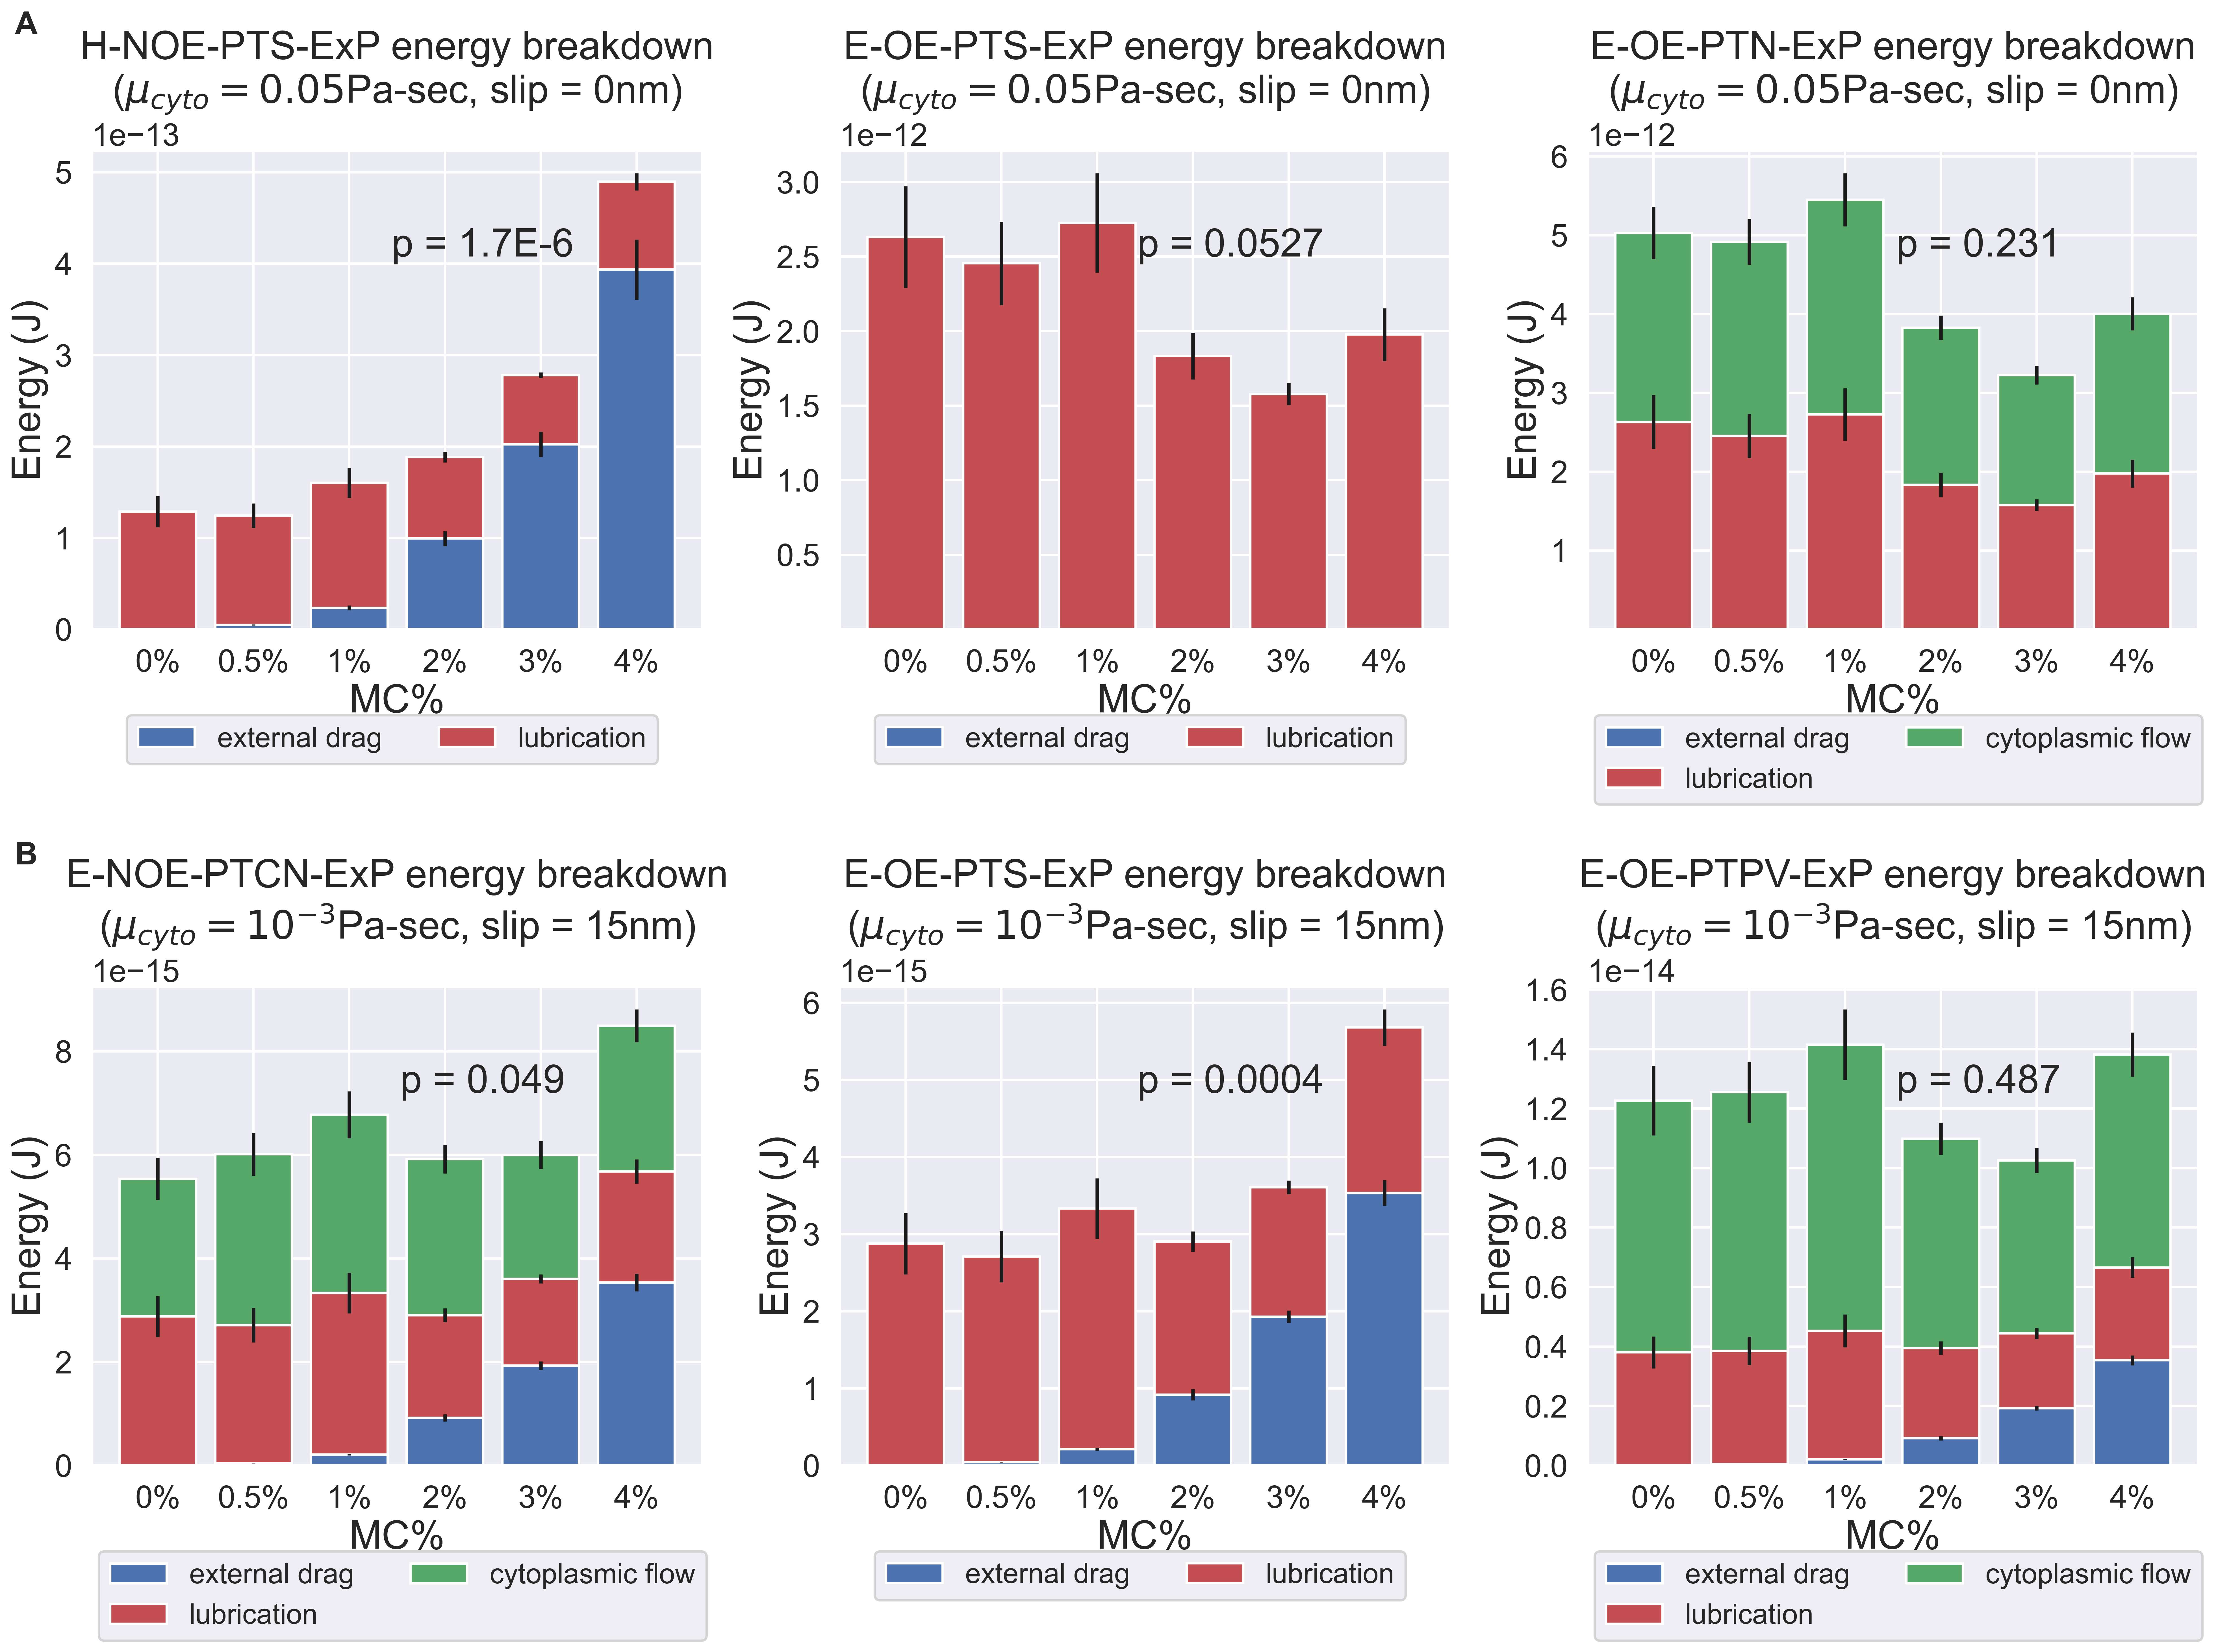

In [60]:
result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent, mu_cyto = 0.05, delta = 0)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent, mu_cyto = 0.05, delta = 0)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent, mu_cyto = 0.05, delta = 0)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent, mu_cyto = 0.05, delta = 0)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent, mu_cyto = 0.05, delta = 0)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent, mu_cyto = 0.05, delta = 0)

tag = 'FTM'
percent = ['0%', '0.5%', '1%', '2%', '3%', '4%']
E_lub_sheath_mean = []
E_lub_sheath_se = []
E_drag_fulltube_mean = []
E_drag_fulltube_se = []
for result in [result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent]:
    E_drag_fulltube_mean.append(np.mean(result[tag]['E_drag_fulltube']))
    E_drag_fulltube_se.append(np.std(result[tag]['E_drag_fulltube'])/np.sqrt(len(result[tag]['E_drag_fulltube'])))
    E_lub_sheath_mean.append(np.mean(result[tag]['E_lub_sheath']))
    E_lub_sheath_se.append(np.std(result[tag]['E_lub_sheath'])/np.sqrt(len(result[tag]['E_lub_sheath'])))

FTM_summary = {'tag': tag, 'percent': percent, 
               'E_lub_sheath_mean': np.array(E_lub_sheath_mean), 'E_lub_sheath_se': np.array(E_lub_sheath_se),
               'E_drag_fulltube_mean': np.array(E_drag_fulltube_mean), 'E_drag_fulltube_se': np.array(E_drag_fulltube_se)}

tag = 'TMO'
percent = ['0%', '0.5%', '1%', '2%', '3%', '4%']
E_drag_tip_mean = []
E_drag_tip_se = []
E_lub_sheath_mean = []
E_lub_sheath_se = []
E_lub_slip_mean = []
E_lub_slip_se = []
for result in [result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent]:
    E_drag_tip_mean.append(np.mean(result[tag]['E_drag_tip']))
    E_drag_tip_se.append(np.std(result[tag]['E_drag_tip'])/np.sqrt(len(result[tag]['E_drag_tip'])))
    E_lub_sheath_mean.append(np.mean(result[tag]['E_lub_sheath']))
    E_lub_sheath_se.append(np.std(result[tag]['E_lub_sheath'])/np.sqrt(len(result[tag]['E_lub_sheath'])))
    E_lub_slip_mean.append(np.mean(result[tag]['E_lub_slip']))
    E_lub_slip_se.append(np.std(result[tag]['E_lub_slip'])/np.sqrt(len(result[tag]['E_lub_slip'])))

TMO_summary = {'tag': tag, 'percent': percent,
               'E_drag_tip_mean': np.array(E_drag_tip_mean), 'E_drag_tip_se': np.array(E_drag_tip_se),
               'E_lub_sheath_mean': np.array(E_lub_sheath_mean), 'E_lub_sheath_se': np.array(E_lub_sheath_se),
               'E_lub_slip_mean': np.array(E_lub_slip_mean), 'E_lub_slip_se': np.array(E_lub_slip_se),
               }

tag = 'TME'
percent = ['0%', '0.5%', '1%', '2%', '3%', '4%']
E_drag_tip_mean = []
E_drag_tip_se = []
E_lub_sheath_mean = []
E_lub_sheath_se = []
E_lub_slip_mean = []
E_lub_slip_se = []
E_cytoplasm_mean = []
E_cytoplasm_se = []
E_tubecontent_mean = []
E_tubecontent_se = []
for result in [result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent]:
    E_drag_tip_mean.append(np.mean(result[tag]['E_drag_tip']))
    E_drag_tip_se.append(np.std(result[tag]['E_drag_tip'])/np.sqrt(len(result[tag]['E_drag_tip'])))
    E_lub_sheath_mean.append(np.mean(result[tag]['E_lub_sheath']))
    E_lub_sheath_se.append(np.std(result[tag]['E_lub_sheath'])/np.sqrt(len(result[tag]['E_lub_sheath'])))
    E_lub_slip_mean.append(np.mean(result[tag]['E_lub_slip']))
    E_lub_slip_se.append(np.std(result[tag]['E_lub_slip'])/np.sqrt(len(result[tag]['E_lub_slip'])))
    E_cytoplasm_mean.append(np.mean(result[tag]['E_cytoplasm']))
    E_cytoplasm_se.append(np.std(result[tag]['E_cytoplasm'])/np.sqrt(len(result[tag]['E_cytoplasm'])))
    E_tubecontent_mean.append(np.mean(result[tag]['E_tubecontent']))
    E_tubecontent_se.append(np.std(result[tag]['E_tubecontent'])/np.sqrt(len(result[tag]['E_tubecontent'])))

TME_summary = {'tag': tag, 'percent': percent,
               'E_drag_tip_mean': np.array(E_drag_tip_mean), 'E_drag_tip_se': np.array(E_drag_tip_se),
               'E_lub_sheath_mean': np.array(E_lub_sheath_mean), 'E_lub_sheath_se': np.array(E_lub_sheath_se),
               'E_lub_slip_mean': np.array(E_lub_slip_mean), 'E_lub_slip_se': np.array(E_lub_slip_se),
               'E_cytoplasm_mean': np.array(E_cytoplasm_mean), 'E_cytoplasm_se': np.array(E_cytoplasm_se),
               'E_tubecontent_mean': np.array(E_tubecontent_mean), 'E_tubecontent_se': np.array(E_tubecontent_se),
               }

sns.set_context('talk')
fig = plt.figure(dpi = 400, figsize = (20,15))
plt.subplot(2,3,1)
p1 = plt.bar(FTM_summary['percent'], FTM_summary['E_drag_fulltube_mean'], yerr = FTM_summary['E_drag_fulltube_se'], 
             label = 'external drag', color = 'C0')
p2 = plt.bar(FTM_summary['percent'], FTM_summary['E_lub_sheath_mean'], bottom = FTM_summary['E_drag_fulltube_mean'], 
             yerr = FTM_summary['E_lub_sheath_se'], label = 'lubrication', color = 'C3')
plt.legend(bbox_to_anchor = (0.95,-0.15), ncol=2, prop={'size':18})
plt.xlabel('MC%', fontsize = 25)
plt.ylabel('Energy (J)', fontsize = 25)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.gca().yaxis.get_offset_text().set_fontsize(20)
plt.text(0.64, 0.8, 'p = 1.7E-6', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes, fontsize = 25)
plt.title('H-NOE-PTS-ExP energy breakdown\n'+r'($\mu_{cyto}=0.05$Pa-sec, slip = 0nm)', fontsize = 25, y=1.08)

plt.subplot(2,3,2)
p1 = plt.bar(TMO_summary['percent'], TMO_summary['E_drag_tip_mean'], yerr = TMO_summary['E_drag_tip_se'], 
             label = 'external drag', color = 'C0')
p2 = plt.bar(TMO_summary['percent'], TMO_summary['E_lub_sheath_mean'] + TMO_summary['E_lub_slip_mean'], 
             bottom = TMO_summary['E_drag_tip_mean'], 
             yerr = TMO_summary['E_lub_sheath_se'] + TMO_summary['E_lub_slip_se'], 
             label = 'lubrication', color = 'C3')
plt.legend(bbox_to_anchor = (0.95,-0.15), ncol=2, prop={'size':18})
plt.xlabel('MC%', fontsize = 25)
plt.ylabel('Energy (J)', fontsize = 25)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.gca().yaxis.get_offset_text().set_fontsize(20)
plt.text(0.64, 0.8, 'p = 0.0527', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes, fontsize = 25)
plt.title('E-OE-PTS-ExP energy breakdown\n'+r'($\mu_{cyto}=0.05$Pa-sec, slip = 0nm)', fontsize = 25, y=1.08)

plt.subplot(2,3,3)
p1 = plt.bar(TME_summary['percent'], TME_summary['E_drag_tip_mean'], yerr = TME_summary['E_drag_tip_se'], 
             label = 'external drag', color = 'C0')
p2 = plt.bar(TME_summary['percent'], 
             TME_summary['E_lub_sheath_mean'] + TME_summary['E_lub_slip_mean'], 
             bottom = TME_summary['E_drag_tip_mean'], 
             yerr = TME_summary['E_lub_sheath_se'] + TME_summary['E_lub_slip_se'], 
             label = 'lubrication', color = 'C3')
p3 = plt.bar(TME_summary['percent'], 
             TME_summary['E_cytoplasm_mean'] + TME_summary['E_tubecontent_mean'], 
             bottom = TME_summary['E_drag_tip_mean']+TME_summary['E_lub_sheath_mean']+TME_summary['E_lub_slip_mean'], 
             yerr = TME_summary['E_cytoplasm_se'] + TME_summary['E_tubecontent_se'], 
             label = 'cytoplasmic flow', color = 'C2')
plt.legend(bbox_to_anchor = (1.03,-0.15), ncol=2, prop={'size':18})
plt.xlabel('MC%', fontsize = 25)
plt.ylabel('Energy (J)', fontsize = 25)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.gca().yaxis.get_offset_text().set_fontsize(20)
plt.text(0.64, 0.8, 'p = 0.231', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes, fontsize = 25)
plt.title('E-OE-PTN-ExP energy breakdown\n'+r'($\mu_{cyto}=0.05$Pa-sec, slip = 0nm)', fontsize = 25, y=1.08)

result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent, mu_cyto = 0.001, delta = 15E-9)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent, mu_cyto = 0.001, delta = 15E-9)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent, mu_cyto = 0.001, delta = 15E-9)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent, mu_cyto = 0.001, delta = 15E-9)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent, mu_cyto = 0.001, delta = 15E-9)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent, mu_cyto = 0.001, delta = 15E-9)

tag = 'TMC'
percent = ['0%', '0.5%', '1%', '2%', '3%', '4%']
E_drag_tip_mean = []
E_drag_tip_se = []
E_lub_sheath_mean = []
E_lub_sheath_se = []
E_lub_slip_mean = []
E_lub_slip_se = []
E_cytoplasm_mean = []
E_cytoplasm_se = []
for result in [result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent]:
    E_drag_tip_mean.append(np.mean(result[tag]['E_drag_tip']))
    E_drag_tip_se.append(np.std(result[tag]['E_drag_tip'])/np.sqrt(len(result[tag]['E_drag_tip'])))
    E_lub_sheath_mean.append(np.mean(result[tag]['E_lub_sheath']))
    E_lub_sheath_se.append(np.std(result[tag]['E_lub_sheath'])/np.sqrt(len(result[tag]['E_lub_sheath'])))
    E_lub_slip_mean.append(np.mean(result[tag]['E_lub_slip']))
    E_lub_slip_se.append(np.std(result[tag]['E_lub_slip'])/np.sqrt(len(result[tag]['E_lub_slip'])))
    E_cytoplasm_mean.append(np.mean(result[tag]['E_cytoplasm']))
    E_cytoplasm_se.append(np.std(result[tag]['E_cytoplasm'])/np.sqrt(len(result[tag]['E_cytoplasm'])))

TMC_summary = {'tag': tag, 'percent': percent,
               'E_drag_tip_mean': np.array(E_drag_tip_mean), 'E_drag_tip_se': np.array(E_drag_tip_se),
               'E_lub_sheath_mean': np.array(E_lub_sheath_mean), 'E_lub_sheath_se': np.array(E_lub_sheath_se),
               'E_lub_slip_mean': np.array(E_lub_slip_mean), 'E_lub_slip_se': np.array(E_lub_slip_se),
               'E_cytoplasm_mean': np.array(E_cytoplasm_mean), 'E_cytoplasm_se': np.array(E_cytoplasm_se),
               }

tag = 'TMO'
percent = ['0%', '0.5%', '1%', '2%', '3%', '4%']
E_drag_tip_mean = []
E_drag_tip_se = []
E_lub_sheath_mean = []
E_lub_sheath_se = []
E_lub_slip_mean = []
E_lub_slip_se = []
for result in [result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent]:
    E_drag_tip_mean.append(np.mean(result[tag]['E_drag_tip']))
    E_drag_tip_se.append(np.std(result[tag]['E_drag_tip'])/np.sqrt(len(result[tag]['E_drag_tip'])))
    E_lub_sheath_mean.append(np.mean(result[tag]['E_lub_sheath']))
    E_lub_sheath_se.append(np.std(result[tag]['E_lub_sheath'])/np.sqrt(len(result[tag]['E_lub_sheath'])))
    E_lub_slip_mean.append(np.mean(result[tag]['E_lub_slip']))
    E_lub_slip_se.append(np.std(result[tag]['E_lub_slip'])/np.sqrt(len(result[tag]['E_lub_slip'])))

TMO_summary = {'tag': tag, 'percent': percent,
               'E_drag_tip_mean': np.array(E_drag_tip_mean), 'E_drag_tip_se': np.array(E_drag_tip_se),
               'E_lub_sheath_mean': np.array(E_lub_sheath_mean), 'E_lub_sheath_se': np.array(E_lub_sheath_se),
               'E_lub_slip_mean': np.array(E_lub_slip_mean), 'E_lub_slip_se': np.array(E_lub_slip_se),
               }

tag = 'TMEP'
percent = ['0%', '0.5%', '1%', '2%', '3%', '4%']
E_drag_tip_mean = []
E_drag_tip_se = []
E_lub_sheath_mean = []
E_lub_sheath_se = []
E_lub_slip_mean = []
E_lub_slip_se = []
E_lub_cell_mean = []
E_lub_cell_se = []
E_cytoplasm_mean = []
E_cytoplasm_se = []
E_tubecontent_mean = []
E_tubecontent_se = []

for result in [result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent]:
    E_drag_tip_mean.append(np.mean(result[tag]['E_drag_tip']))
    E_drag_tip_se.append(np.std(result[tag]['E_drag_tip'])/np.sqrt(len(result[tag]['E_drag_tip'])))
    E_lub_sheath_mean.append(np.mean(result[tag]['E_lub_sheath']))
    E_lub_sheath_se.append(np.std(result[tag]['E_lub_sheath'])/np.sqrt(len(result[tag]['E_lub_sheath'])))
    E_lub_slip_mean.append(np.mean(result[tag]['E_lub_slip']))
    E_lub_slip_se.append(np.std(result[tag]['E_lub_slip'])/np.sqrt(len(result[tag]['E_lub_slip'])))
    E_lub_cell_mean.append(np.mean(result[tag]['E_lub_cell']))
    E_lub_cell_se.append(np.std(result[tag]['E_lub_cell'])/np.sqrt(len(result[tag]['E_lub_cell'])))
    E_cytoplasm_mean.append(np.mean(result[tag]['E_cytoplasm']))
    E_cytoplasm_se.append(np.std(result[tag]['E_cytoplasm'])/np.sqrt(len(result[tag]['E_cytoplasm'])))
    E_tubecontent_mean.append(np.mean(result[tag]['E_tubecontent']))
    E_tubecontent_se.append(np.std(result[tag]['E_tubecontent'])/np.sqrt(len(result[tag]['E_tubecontent'])))

TMEP_summary = {'tag': tag, 'percent': percent,
               'E_drag_tip_mean': np.array(E_drag_tip_mean), 'E_drag_tip_se': np.array(E_drag_tip_se),
               'E_lub_sheath_mean': np.array(E_lub_sheath_mean), 'E_lub_sheath_se': np.array(E_lub_sheath_se),
               'E_lub_slip_mean': np.array(E_lub_slip_mean), 'E_lub_slip_se': np.array(E_lub_slip_se),
               'E_lub_cell_mean': np.array(E_lub_cell_mean), 'E_lub_cell_se': np.array(E_lub_cell_se),
               'E_cytoplasm_mean': np.array(E_cytoplasm_mean), 'E_cytoplasm_se': np.array(E_cytoplasm_se),
               'E_tubecontent_mean': np.array(E_tubecontent_mean), 'E_tubecontent_se': np.array(E_tubecontent_se),
               }

plt.subplot(2,3,4)
p1 = plt.bar(TMC_summary['percent'], TMC_summary['E_drag_tip_mean'], 
             yerr = TMC_summary['E_drag_tip_se'], 
             label = 'external drag', color = 'C0')
p2 = plt.bar(TMC_summary['percent'], 
             TMC_summary['E_lub_sheath_mean'] + TMC_summary['E_lub_slip_mean'], 
             bottom = TMC_summary['E_drag_tip_mean'], 
             yerr = TMC_summary['E_lub_sheath_se'] + TMC_summary['E_lub_slip_se'], 
             label = 'lubrication', color = 'C3')
p3 = plt.bar(TMC_summary['percent'], 
             TMC_summary['E_cytoplasm_mean'], 
             bottom = TMC_summary['E_drag_tip_mean']+TMC_summary['E_lub_sheath_mean']+TMC_summary['E_lub_slip_mean'], 
             yerr = TMC_summary['E_cytoplasm_se'], 
             label = 'cytoplasmic flow', color = 'C2')
plt.legend(bbox_to_anchor = (1.03,-0.15), ncol=2, prop={'size':18})
plt.xlabel('MC%', fontsize = 25)
plt.ylabel('Energy (J)', fontsize = 25)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.gca().yaxis.get_offset_text().set_fontsize(20)
plt.text(0.64, 0.8, 'p = 0.049', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes, fontsize = 25)
plt.title('E-NOE-PTCN-ExP energy breakdown\n'+r'($\mu_{cyto}=10^{-3}$Pa-sec, slip = 15nm)', fontsize = 25, y=1.08)
plt.subplot(2,3,5)
p1 = plt.bar(TMO_summary['percent'], TMO_summary['E_drag_tip_mean'], yerr = TMO_summary['E_drag_tip_se'], 
             label = 'external drag', color = 'C0')
p2 = plt.bar(TMO_summary['percent'], TMO_summary['E_lub_sheath_mean'] + TMO_summary['E_lub_slip_mean'], 
             bottom = TMO_summary['E_drag_tip_mean'], 
             yerr = TMO_summary['E_lub_sheath_se'] + TMO_summary['E_lub_slip_se'], 
             label = 'lubrication', color = 'C3')
plt.legend(bbox_to_anchor = (0.95,-0.15), ncol=2, prop={'size':18})
plt.xlabel('MC%', fontsize = 25)
plt.ylabel('Energy (J)', fontsize = 25)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.gca().yaxis.get_offset_text().set_fontsize(20)
plt.text(0.64, 0.8, 'p = 0.0004', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes, fontsize = 25)
plt.title('E-OE-PTS-ExP energy breakdown\n'+r'($\mu_{cyto}=10^{-3}$Pa-sec, slip = 15nm)', fontsize = 25, y=1.08)
plt.subplot(2,3,6)
p1 = plt.bar(TMEP_summary['percent'], 
             TMEP_summary['E_drag_tip_mean'], 
             yerr = TMEP_summary['E_drag_tip_se'], 
             label = 'external drag', color = 'C0')
p2 = plt.bar(TMEP_summary['percent'], 
             TMEP_summary['E_lub_sheath_mean'] + TMEP_summary['E_lub_slip_mean'] + TMEP_summary['E_lub_cell_mean'], 
             bottom = TMEP_summary['E_drag_tip_mean'], 
             yerr = TMEP_summary['E_lub_sheath_se'] + TMEP_summary['E_lub_slip_se'] + TMEP_summary['E_lub_cell_se'], 
             label = 'lubrication', color = 'C3')
p3 = plt.bar(TMEP_summary['percent'], 
             TMEP_summary['E_cytoplasm_mean'] + TMEP_summary['E_tubecontent_mean'], 
             bottom = TMEP_summary['E_drag_tip_mean']+TMEP_summary['E_lub_sheath_mean']+TMEP_summary['E_lub_slip_mean']+TMEP_summary['E_lub_cell_mean'], 
             yerr = TMEP_summary['E_cytoplasm_se'] + TMEP_summary['E_tubecontent_se'], 
             label = 'cytoplasmic flow', color = 'C2')
plt.legend(bbox_to_anchor = (1.03,-0.15), ncol=2, prop={'size':18})
plt.xlabel('MC%', fontsize = 25)
plt.ylabel('Energy (J)', fontsize = 25)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.gca().yaxis.get_offset_text().set_fontsize(20)
plt.text(0.64, 0.8, 'p = 0.487', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes, fontsize = 25)
plt.title('E-OE-PTPV-ExP energy breakdown\n'+r'($\mu_{cyto}=10^{-3}$Pa-sec, slip = 15nm)', fontsize = 25, y=1.08)
plt.tight_layout()
fig.text(0.02, 0.98, 'A', fontweight = 'bold', va='center', fontsize = 20)
fig.text(0.02, 0.49, 'B', fontweight = 'bold', va='center', fontsize = 20)
plt.savefig(output_path+'Fig5.png', bbox_inches='tight')
plt.show()

## Fig 3C

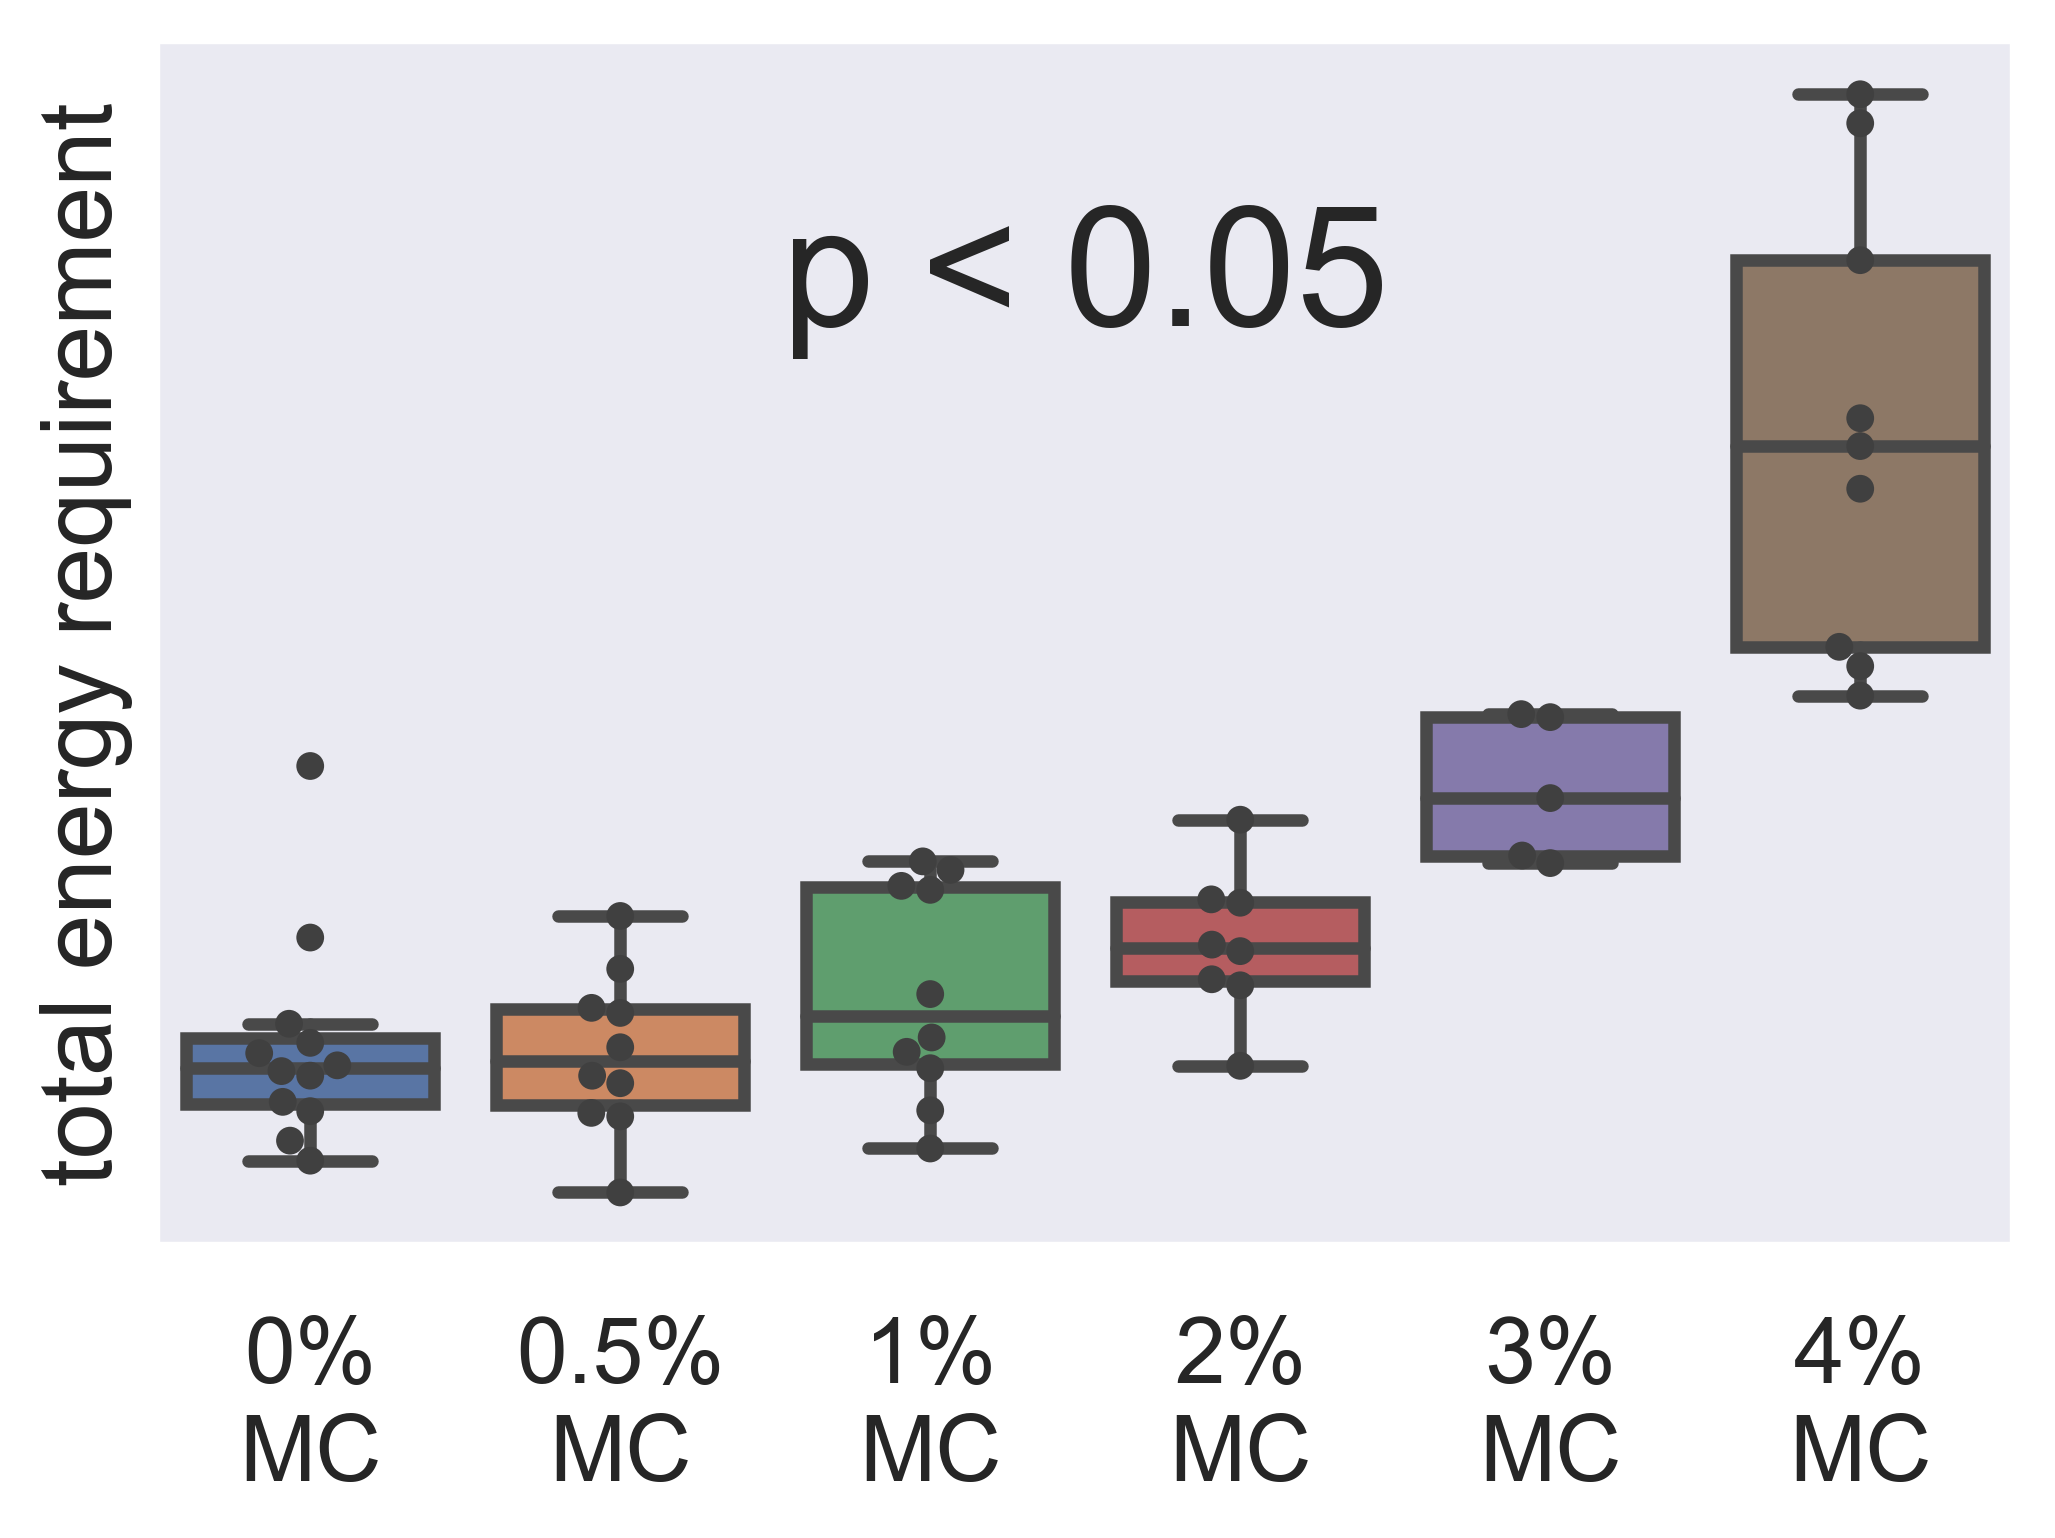

In [12]:
text = ['0%\nMC', '0.5%\nMC', '1%\nMC', '2%\nMC', '3%\nMC', '4%\nMC']
sns.set_context('talk')
result = result_summarized_mucyto5EN2
fig = plt.figure(dpi = 400)
sns.boxplot(data = result['E_FTM_all'], showfliers = False)
sns.swarmplot(data = result['E_FTM_all'], color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.text(0.5, 0.8, 'p < 0.05', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes, fontsize = 30)
plt.gca().axes.yaxis.set_ticks([])
plt.ylabel('total energy requirement')
plt.savefig(output_path + 'significant_demo.jpg', bbox_inches='tight')

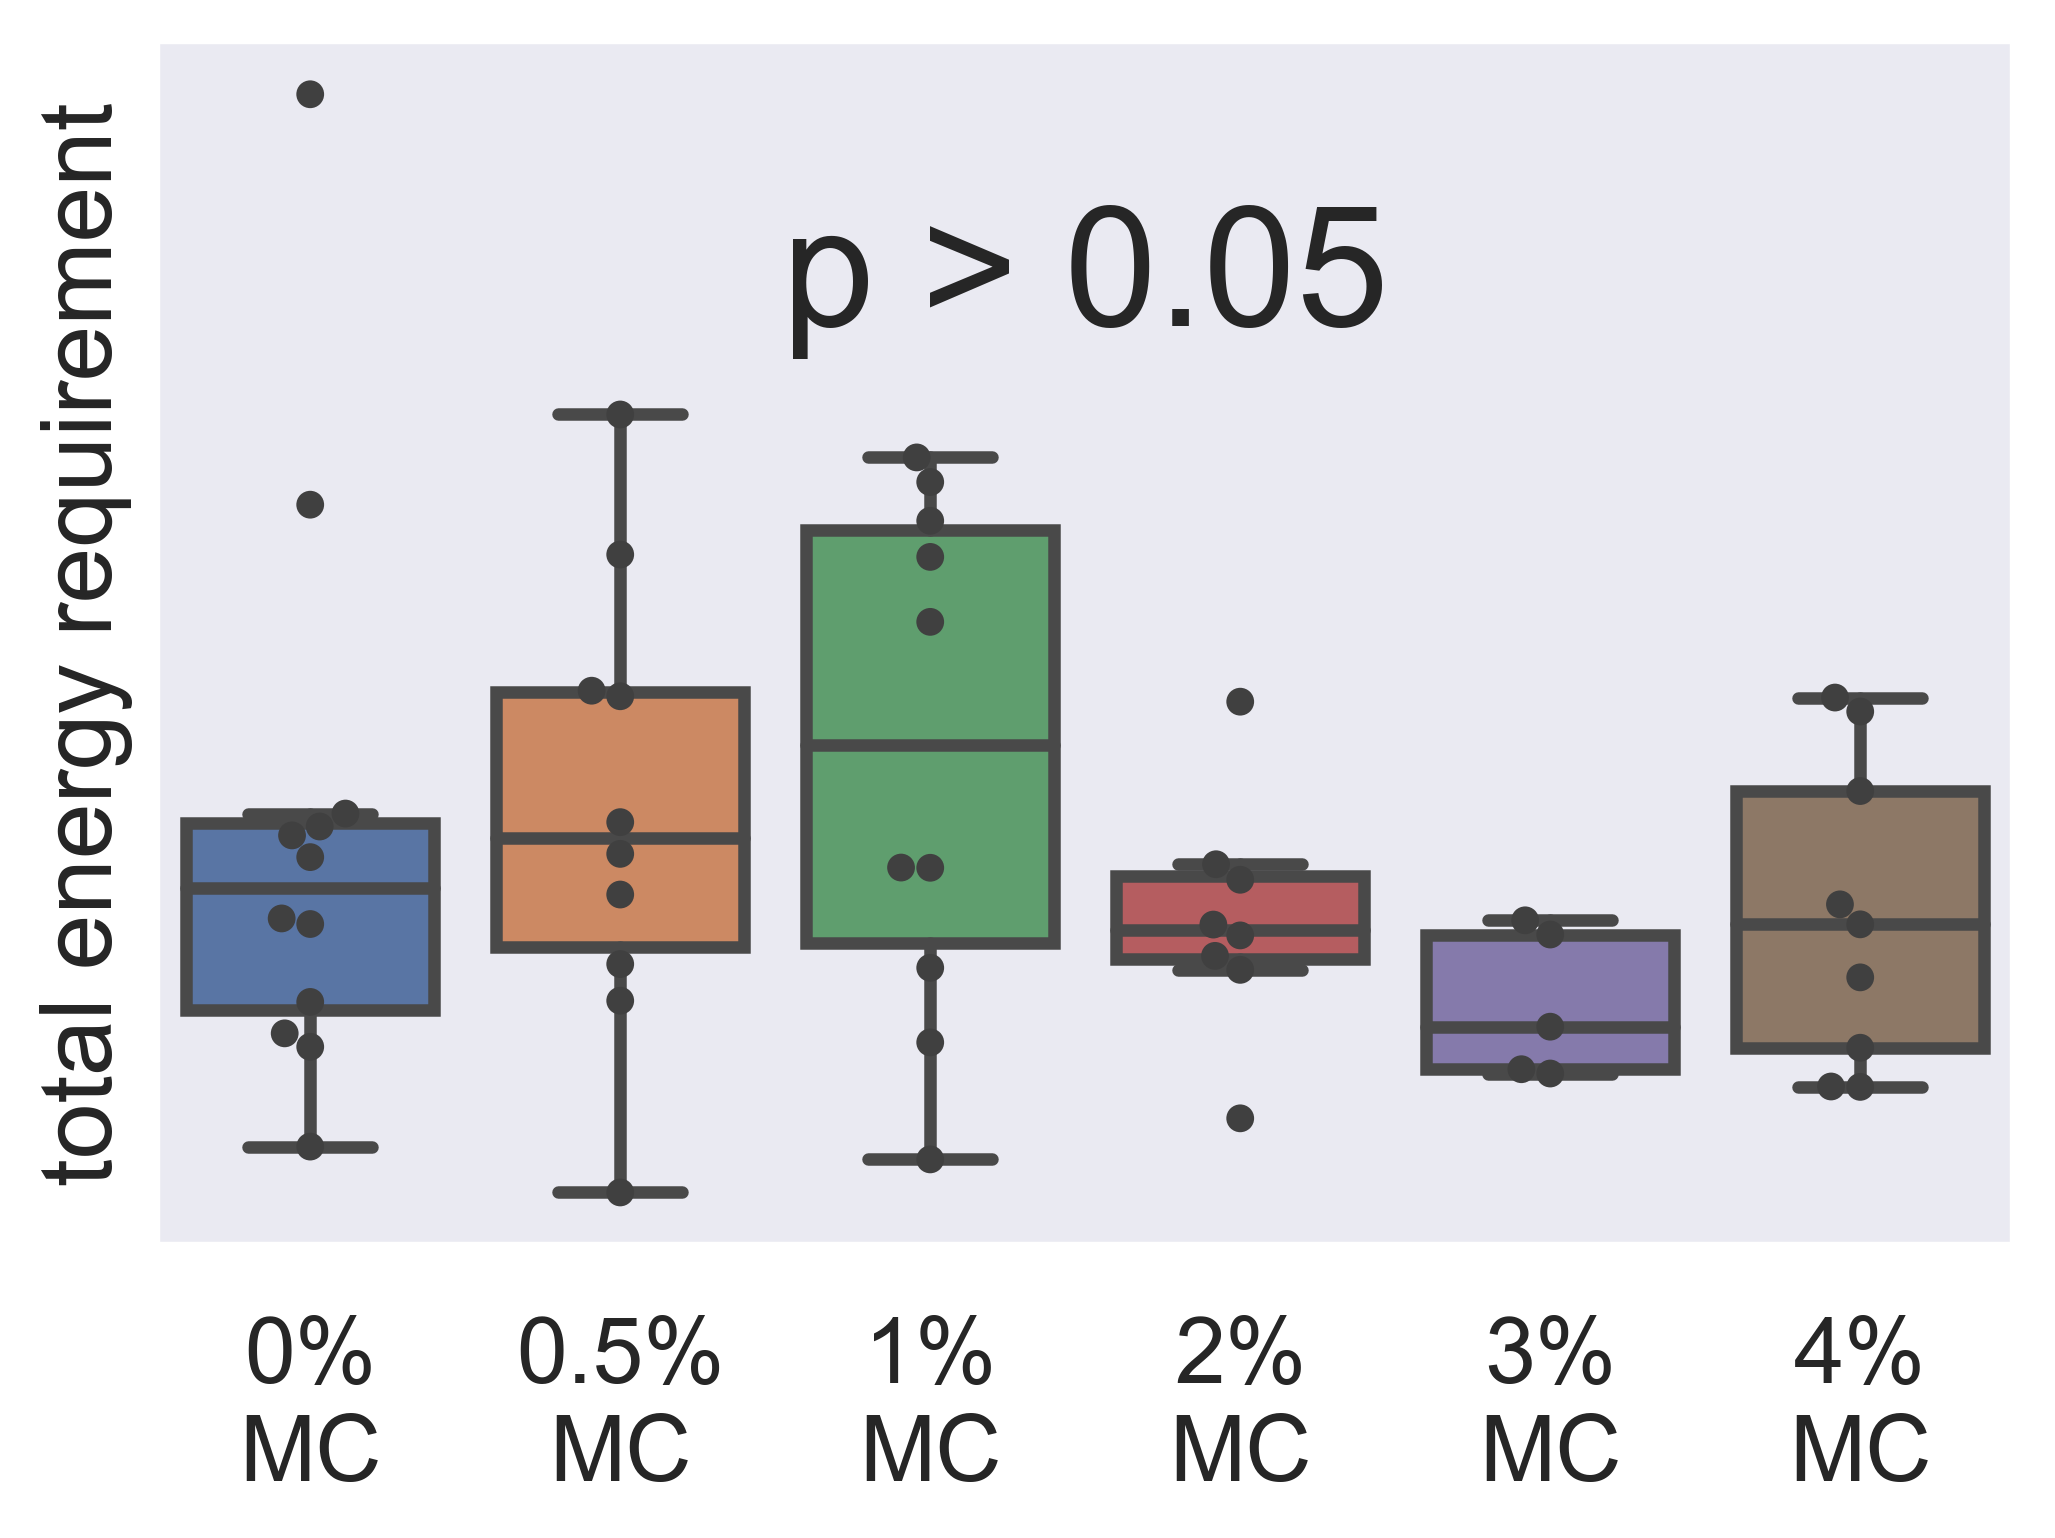

In [11]:
text = ['0%\nMC', '0.5%\nMC', '1%\nMC', '2%\nMC', '3%\nMC', '4%\nMC']
sns.set_context('talk')
result = result_summarized_mucyto5EN2
fig = plt.figure(dpi = 400)
sns.boxplot(data = result['E_TMEP_all'], showfliers = False)
sns.swarmplot(data = result['E_TMEP_all'], color=".25")
plt.xticks(ticks = range(6), labels = text)
plt.text(0.5, 0.8, 'p > 0.05', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes, fontsize = 30)
plt.gca().axes.yaxis.set_ticks([])
plt.ylabel('total energy requirement')
plt.savefig(output_path + 'nonsignificant_demo.jpg', bbox_inches='tight')

## Fig 6

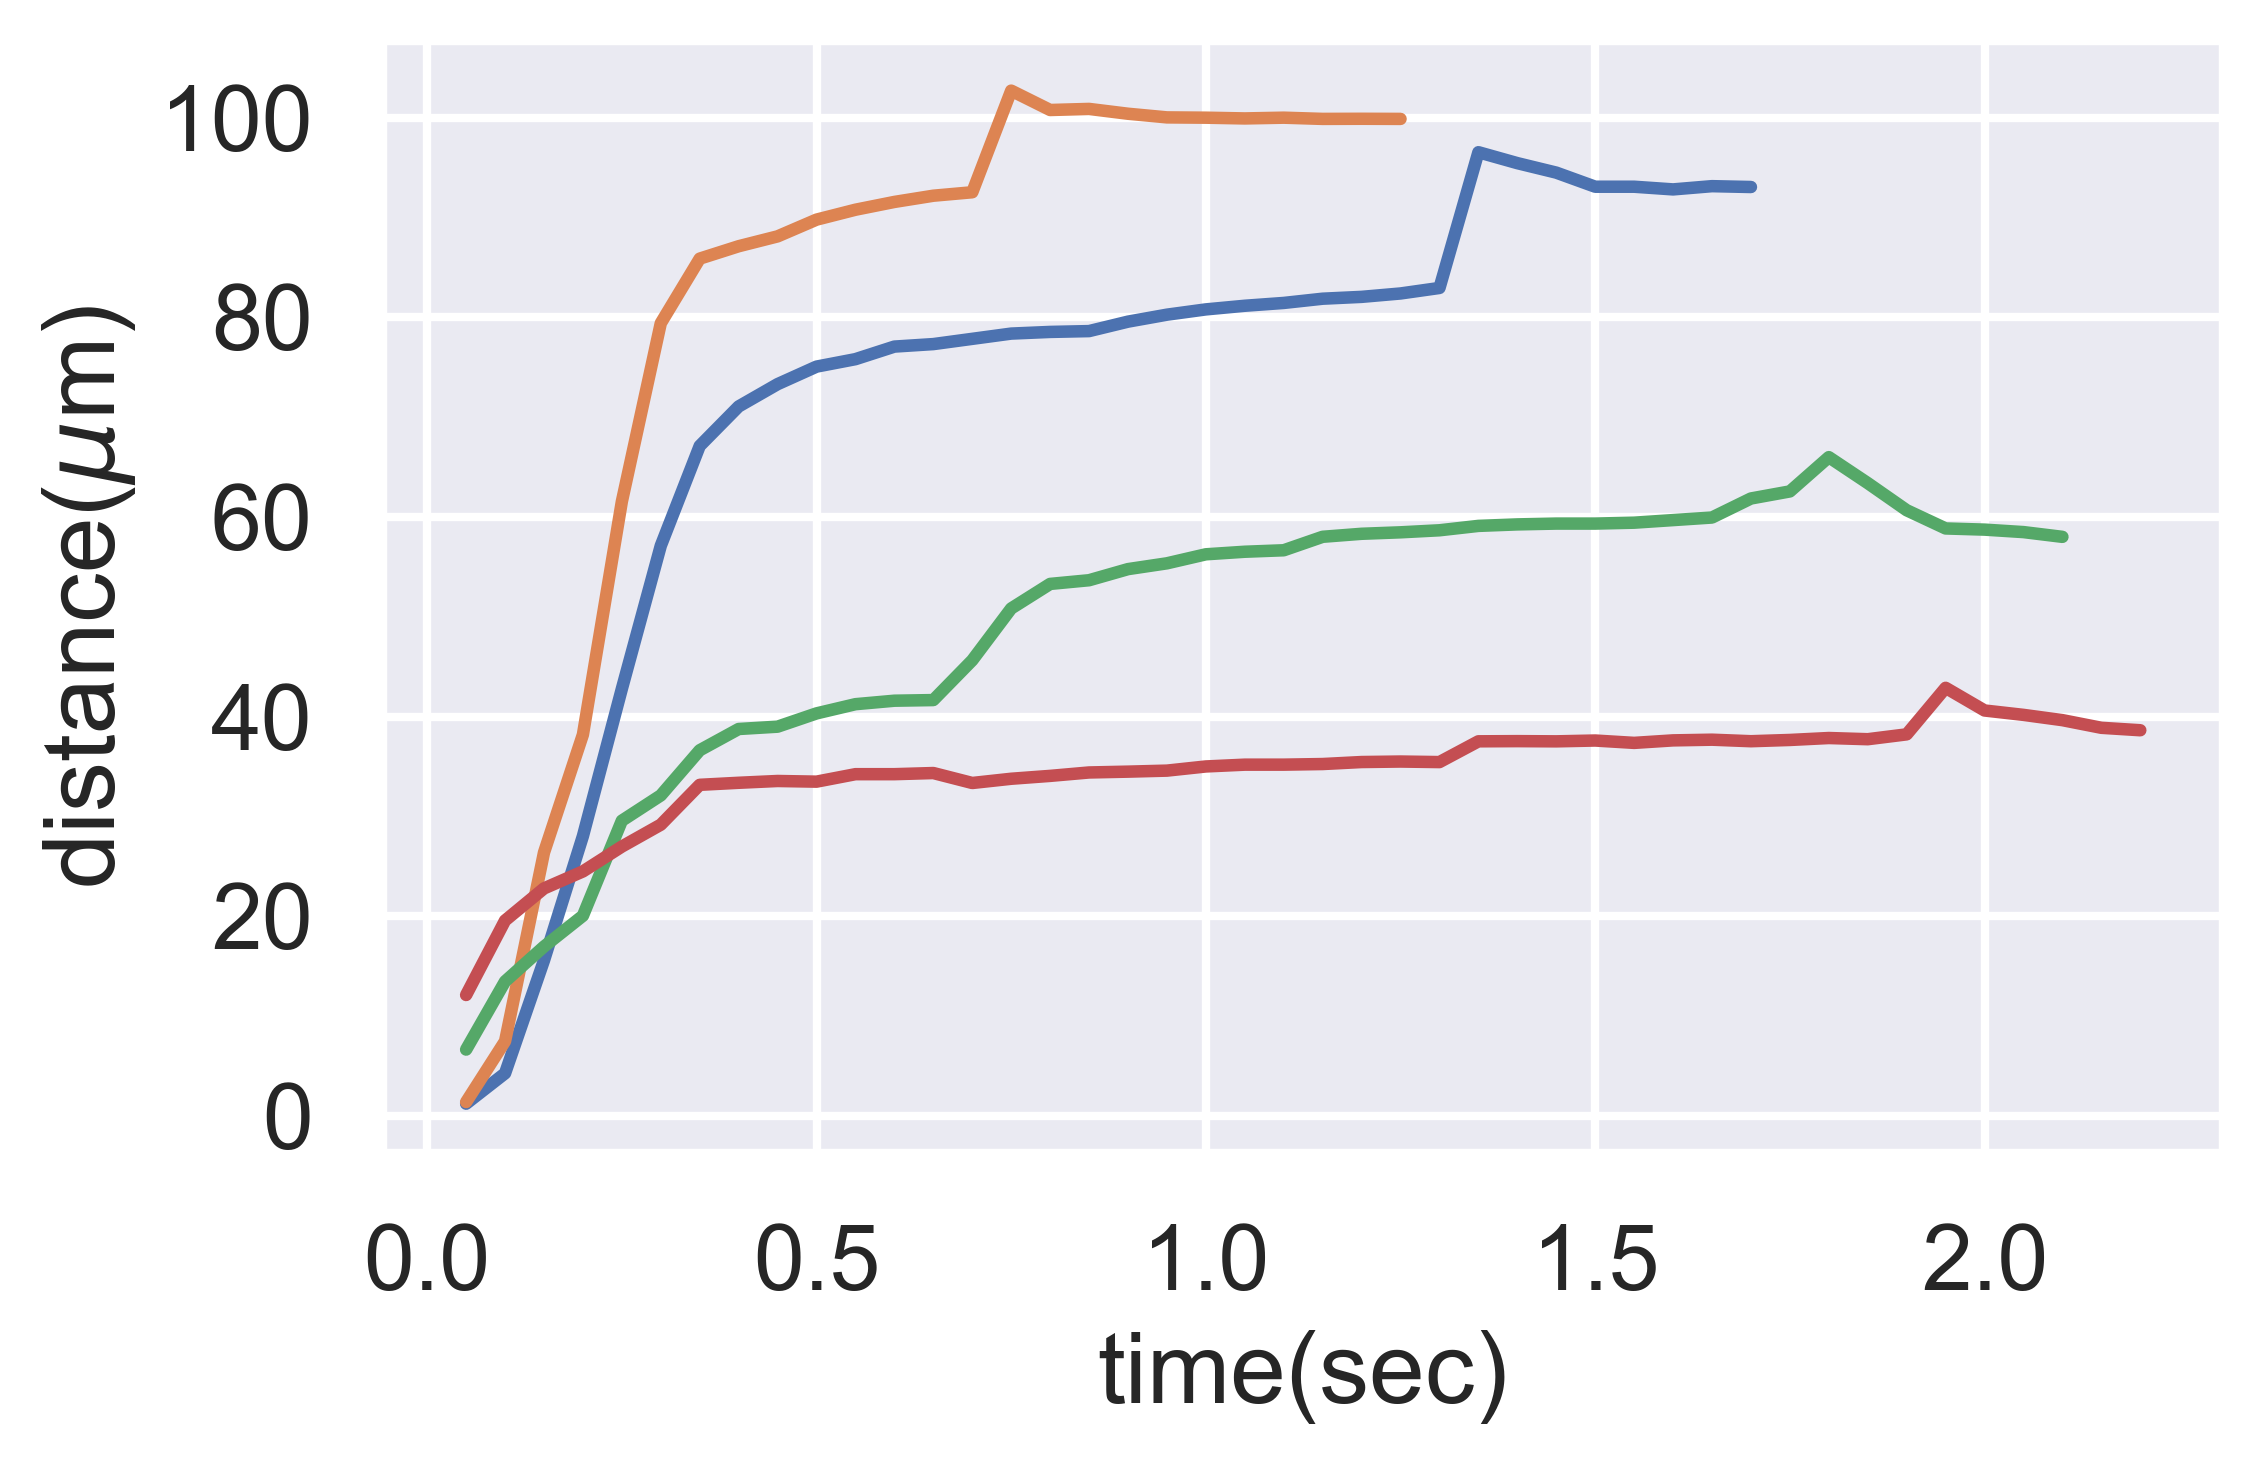

In [3]:
plt.figure(dpi = 400)
sns.set_context('talk')
file_name = 'Nuclear_translocation_measurement.xlsx'
df_nuc = pd.read_excel(data_path + file_name)
df_time = df_nuc['Time(s)']
df_nuc = df_nuc.drop(columns='Time(s)')
for label, content in df_nuc.items():
    plt.plot(df_time, content)
plt.xlabel('time(sec)')
plt.ylabel(r'distance($\mu$m)')
plt.tight_layout()
#plt.title('experimental data of nucleus movement')
plt.savefig('nucleus_experiment.png', bbox_inches='tight')
plt.show()

In [17]:
mu_cyto = 0.05
result_0_percent = analyze_kinematics_new('PT_kinematics_0%MC.xlsx', mu_surrounding = mu_0_percent, mu_cyto = mu_cyto, delta = 0)
result_05_percent = analyze_kinematics_new('PT_kinematics_0.5%MC.xlsx', mu_surrounding = mu_05_percent, mu_cyto = mu_cyto, delta = 0)
result_1_percent = analyze_kinematics_new('PT_kinematics_1%MC_rm85.xlsx', mu_surrounding = mu_1_percent, mu_cyto = mu_cyto, delta = 0)
result_2_percent = analyze_kinematics_new('PT_kinematics_2%MC.xlsx', mu_surrounding = mu_2_percent, mu_cyto = mu_cyto, delta = 0)
result_3_percent = analyze_kinematics_new('PT_kinematics_3%MC.xlsx', mu_surrounding = mu_3_percent, mu_cyto = mu_cyto, delta = 0)
result_4_percent = analyze_kinematics_new('PT_kinematics_4%MC.xlsx', mu_surrounding = mu_4_percent, mu_cyto = mu_cyto, delta = 0)
result_summarized_mucyto5EN2 = summary_statistics_and_plot(result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent)
result = result_summarized_mucyto5EN2

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


54
300
fraction of buckling: 0.07407407407407407
fraction of cavitation: 0.0
fraction of bubble: 0.4444444444444444
mean buckle time: 0.17325000000000002
n buckle: 4
std buckle time: 0.020498475553074668
mean cavitation time: nan
n cavitation: 0
std cavitation time: nan
mean bubble time: 0.198375
n bubble: 24
std bubble time: 0.0820958852501147
54
300
fraction of buckling: 0.48148148148148145
fraction of cavitation: 0.2037037037037037
fraction of bubble: 0.8888888888888888
mean buckle time: 0.5185384615384616
n buckle: 26
std buckle time: 0.33326257039818075
mean cavitation time: 0.7085454545454546
n cavitation: 11
std cavitation time: 0.39175789453932425
mean bubble time: 0.3639375
n bubble: 48
std bubble time: 0.24971220153158316


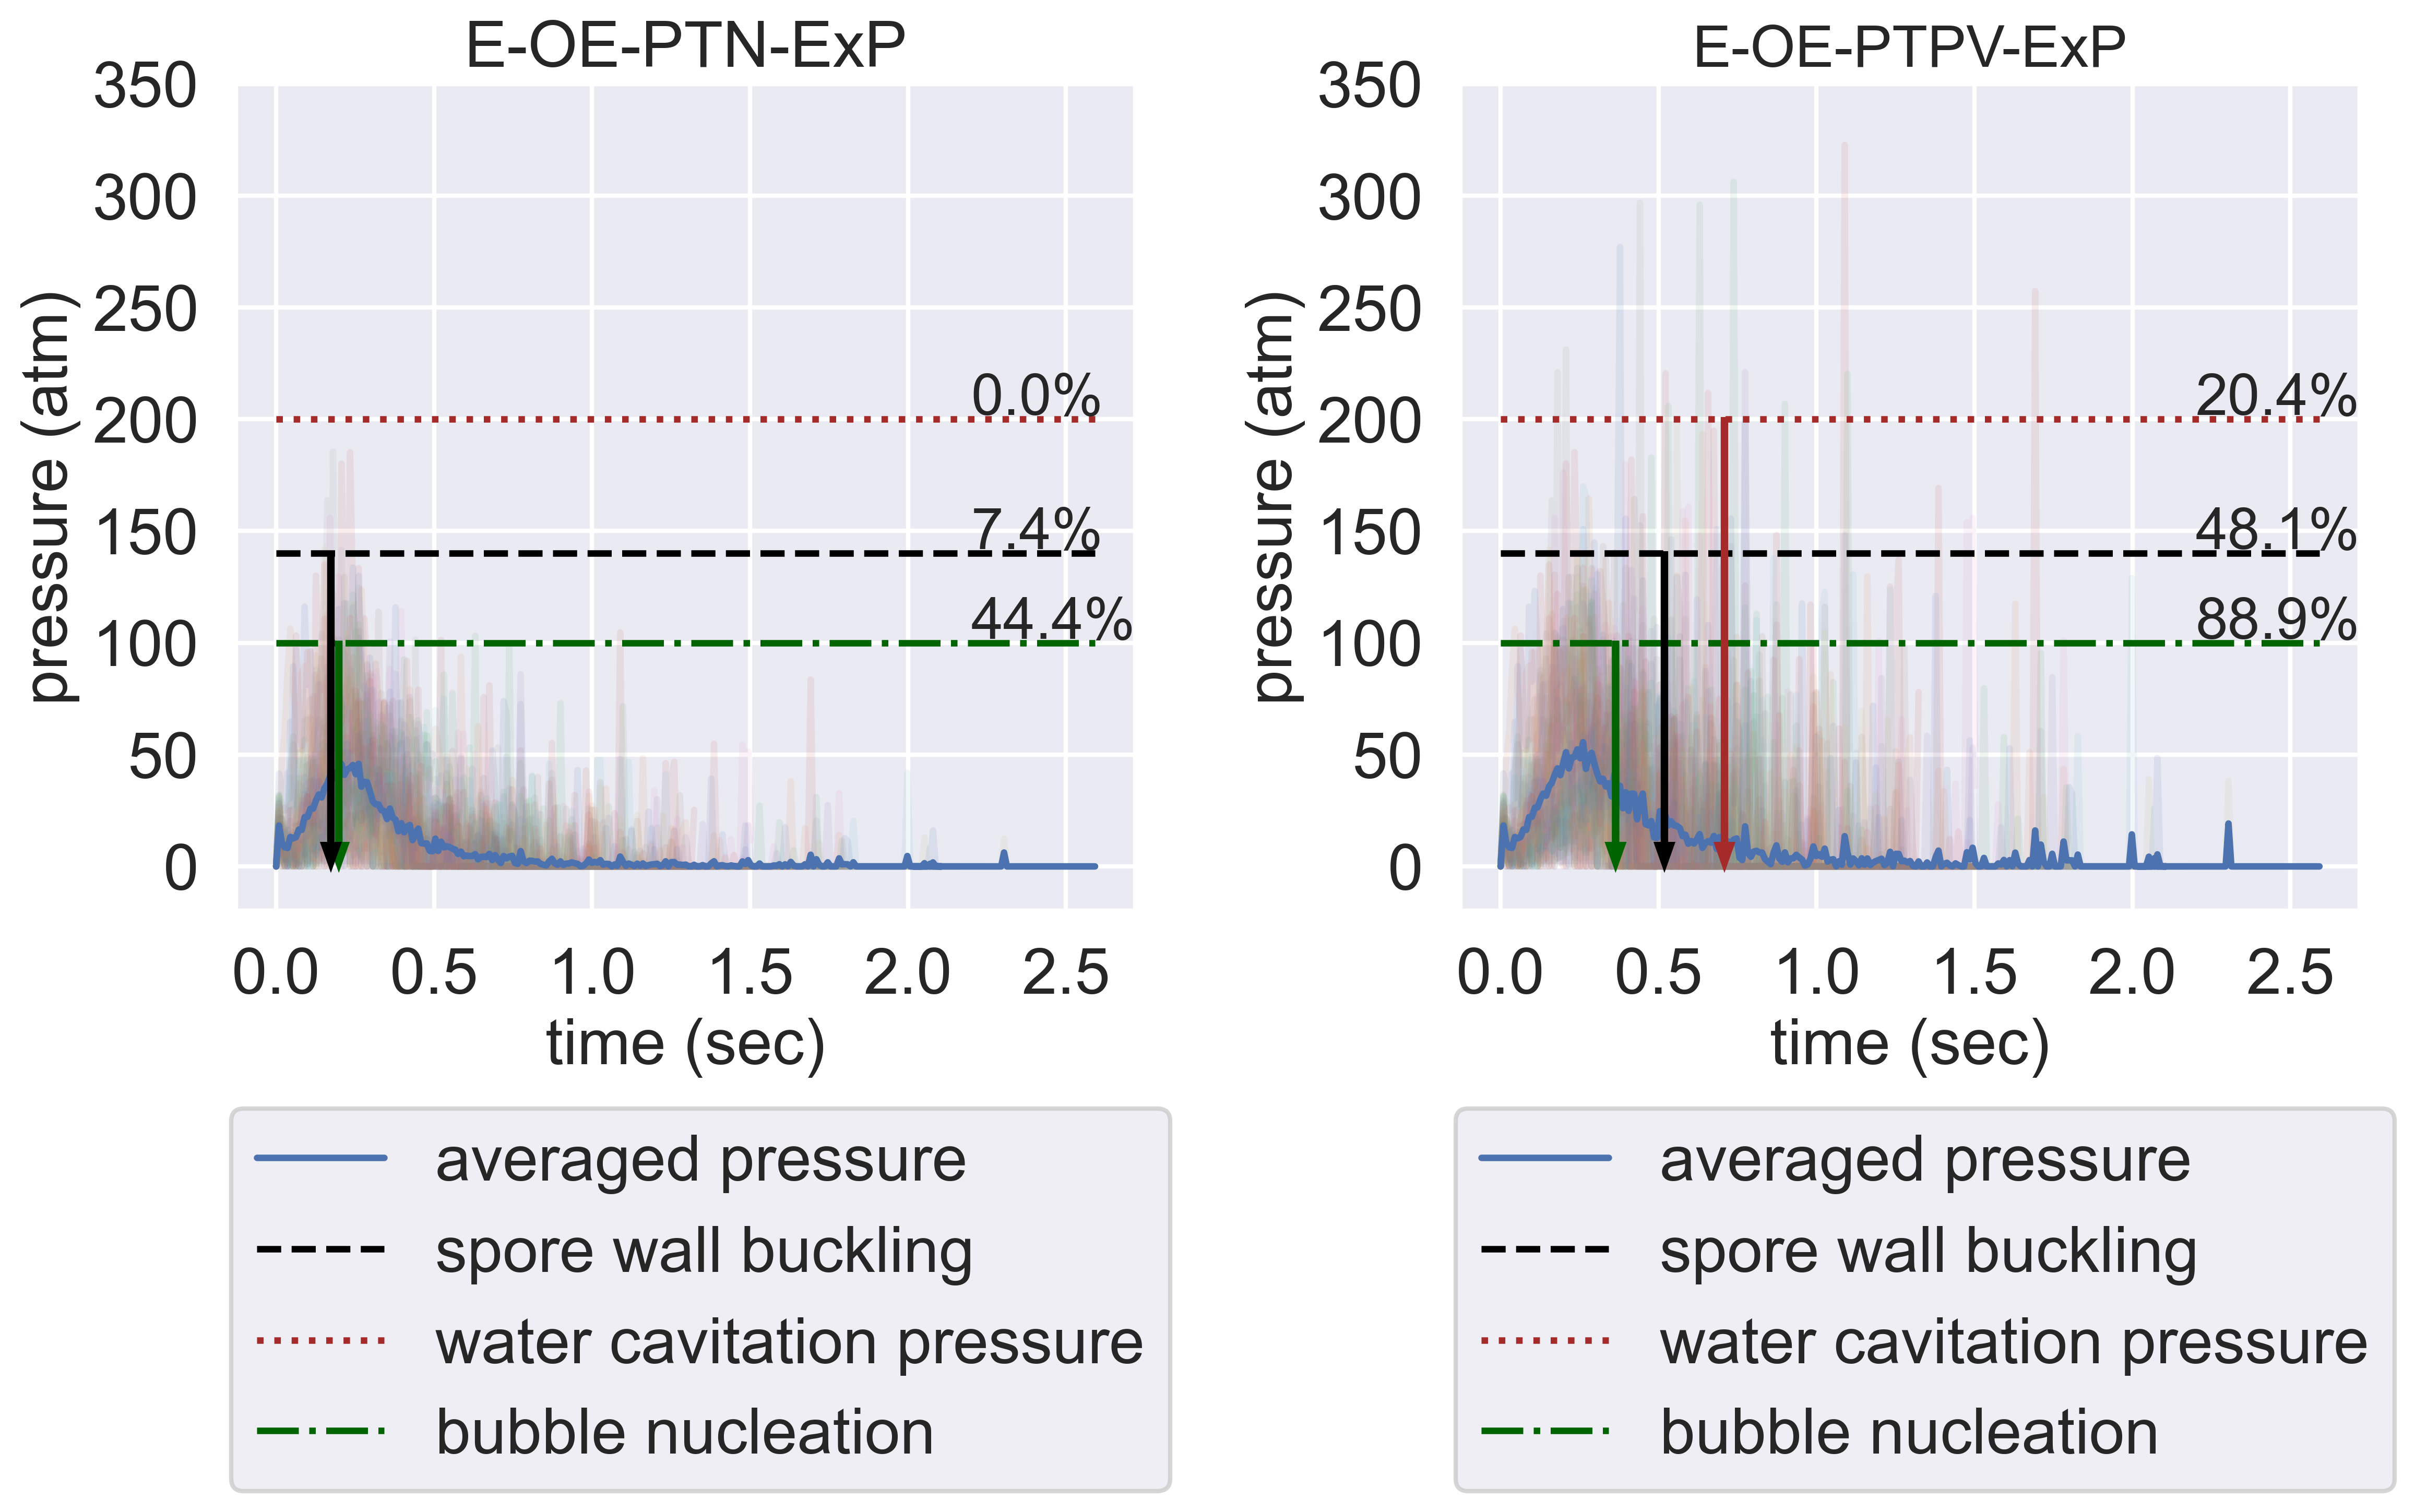

In [21]:
plt.figure(dpi = 400, figsize = (12,8))
sns.set_context('talk')
plt.subplot(1,2,1)
n_sample_total = 0
n_t = 0
time_arr = []
for result in [result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent]:
    n_sample_total += len(result['TME']['P'])
    if len(result['time']) > n_t:
        n_t = len(result['time'])
        time_arr = result['time']
print(n_sample_total)
print(n_t)
p_time_series_array = np.empty((n_t, n_sample_total))
p_time_series_array.fill(np.nan)
i = 0
frac_buckling = 0
frac_water_cav = 0
frac_bubble = 0
t_buckle_all = []
t_water_all = []
t_bubble_all = []
for result in [result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent]:
    for p in result['TME']['P']:
        n = len(p)
        p_time_series_array[0:n, i] = p/101325
        plt.plot(time_arr[0:n], p/101325, alpha = 0.1)
        i+=1
        if max(p)/101325 > 140:
            frac_buckling+=1
            t_buckle_all.append(time_arr[np.min(np.where(p/101325 > 140))])
        if max(p)/101325 > 200:
            frac_water_cav +=1
            t_water_all.append(time_arr[np.min(np.where(p/101325 > 200))])
        if max(p)/101325 > 100:
            frac_bubble +=1
            t_bubble_all.append(time_arr[np.min(np.where(p/101325 > 100))])
frac_buckling /= n_sample_total
frac_water_cav /= n_sample_total
frac_bubble /= n_sample_total
print('fraction of buckling: %s'%frac_buckling)
print('fraction of cavitation: %s'%frac_water_cav)
print('fraction of bubble: %s'%frac_bubble)
print('mean buckle time: %s'%np.mean(t_buckle_all))
print('n buckle: %s'%len(t_buckle_all))
print('std buckle time: %s'%np.std(t_buckle_all))
print('mean cavitation time: %s'%np.mean(t_water_all))
print('n cavitation: %s'%len(t_water_all))
print('std cavitation time: %s'%np.std(t_water_all))
print('mean bubble time: %s'%np.mean(t_bubble_all))
print('n bubble: %s'%len(t_bubble_all))
print('std bubble time: %s'%np.std(t_bubble_all))

plt.plot(time_arr, np.nanmean(p_time_series_array, axis = 1), color = 'C0', label = 'averaged pressure')
plt.hlines(140, min(time_arr), max(time_arr), color = 'black', linestyle = '--', label = 'spore wall buckling')
plt.arrow(np.mean(t_buckle_all), 140, 0, -140, color = 'black', length_includes_head = True, head_width = .05, head_length = 0.1E2,zorder=97, width = 0.01)
plt.text(2.2, 142, '7.4%', fontsize = 20)
plt.hlines(200, min(time_arr), max(time_arr), color = 'brown', linestyle = 'dotted', label = 'water cavitation pressure')
plt.text(2.2, 202, '0.0%', fontsize = 20)
plt.hlines(100, min(time_arr), max(time_arr), color = 'darkgreen', linestyle = '-.', label = 'bubble nucleation')
plt.arrow(np.mean(t_bubble_all), 100, 0, -100, color = 'darkgreen', length_includes_head = True, head_width = .05, head_length = 0.1E2,zorder=96, width = 0.01)
plt.text(2.2, 102, '44.4%', fontsize = 20)
plt.xlabel('time (sec)', fontsize = 22)
plt.ylabel('pressure (atm)', fontsize = 22)
plt.xticks(fontsize = 22); plt.yticks(fontsize = 22)
plt.gca().yaxis.get_offset_text().set_fontsize(22)
plt.legend(loc= 'upper left', bbox_to_anchor = (-0.04, -0.2), fontsize = 22)
plt.ylim([-0.2E2, 3.5E2])
plt.title('E-OE-PTN-ExP', fontsize = 22)

plt.subplot(1,2,2)
n_sample_total = 0
n_t = 0
time_arr = []
for result in [result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent]:
    n_sample_total += len(result['TMEP']['P'])
    if len(result['time']) > n_t:
        n_t = len(result['time'])
        time_arr = result['time']
print(n_sample_total)
print(n_t)
p_time_series_array = np.empty((n_t, n_sample_total))
p_time_series_array.fill(np.nan)
i = 0
frac_buckling = 0
frac_water_cav = 0
frac_bubble = 0
t_buckle_all = []
t_water_all = []
t_bubble_all = []
for result in [result_0_percent, result_05_percent, result_1_percent, result_2_percent, result_3_percent, result_4_percent]:
    for p in result['TMEP']['P']:
        n = len(p)
        p_time_series_array[0:n, i] = p/101325
        plt.plot(time_arr[0:n], p/101325, alpha = 0.1)
        i+=1
        if max(p)/101325 > 140:
            frac_buckling+=1
            t_buckle_all.append(time_arr[np.min(np.where(p/101325 > 140))])
        if max(p)/101325 > 200:
            frac_water_cav +=1
            t_water_all.append(time_arr[np.min(np.where(p/101325 > 200))])
        if max(p)/101325 > 100:
            frac_bubble +=1
            t_bubble_all.append(time_arr[np.min(np.where(p/101325 > 100))])
frac_buckling /= n_sample_total
frac_water_cav /= n_sample_total
frac_bubble /= n_sample_total
print('fraction of buckling: %s'%frac_buckling)
print('fraction of cavitation: %s'%frac_water_cav)
print('fraction of bubble: %s'%frac_bubble)
print('mean buckle time: %s'%np.mean(t_buckle_all))
print('n buckle: %s'%len(t_buckle_all))
print('std buckle time: %s'%np.std(t_buckle_all))
print('mean cavitation time: %s'%np.mean(t_water_all))
print('n cavitation: %s'%len(t_water_all))
print('std cavitation time: %s'%np.std(t_water_all))
print('mean bubble time: %s'%np.mean(t_bubble_all))
print('n bubble: %s'%len(t_bubble_all))
print('std bubble time: %s'%np.std(t_bubble_all))

plt.plot(time_arr, np.nanmean(p_time_series_array, axis = 1), color = 'C0', label = 'averaged pressure')
plt.hlines(140, min(time_arr), max(time_arr), color = 'black', linestyle = '--', label = 'spore wall buckling')
plt.text(2.2, 142, '48.1%', fontsize = 20)
plt.arrow(np.mean(t_buckle_all), 140, 0, -140, color = 'black', length_includes_head = True, head_width = .05, head_length = 0.1E2,zorder=100, width = 0.01)
plt.hlines(200, min(time_arr), max(time_arr), color = 'brown', linestyle = 'dotted', label = 'water cavitation pressure')
plt.text(2.2, 202, '20.4%', fontsize = 20)
plt.arrow(np.mean(t_water_all), 200, 0, -200, color = 'brown', length_includes_head = True, head_width = .05, head_length = 0.1E2,zorder=99, width = 0.01)
plt.hlines(100, min(time_arr), max(time_arr), color = 'darkgreen', linestyle = '-.', label = 'bubble nucleation')
plt.text(2.2, 102, '88.9%', fontsize = 20)
plt.arrow(np.mean(t_bubble_all), 100, 0, -100, color = 'darkgreen', length_includes_head = True, head_width = .05, head_length = 0.1E2,zorder=98, width = 0.01)
plt.xlabel('time (sec)', fontsize = 22)
plt.ylabel('pressure (atm)', fontsize = 22)
plt.xticks(fontsize = 22); plt.yticks(fontsize = 22)
plt.gca().yaxis.get_offset_text().set_fontsize(22)
plt.ylim([-0.2E2, 3.5E2])
plt.legend(loc= 'upper left', bbox_to_anchor = (-0.04, -0.2), fontsize = 22)
plt.title('E-OE-PTPV-ExP', fontsize = 20)
plt.tight_layout()
plt.savefig(output_path + 'Fig6_pressuretime_atm.png', bbox_inches='tight')